# Robustness of a Face Recognition System to Adversarial Attacks

In [1]:
%pip install facenet-pytorch
%pip install Pillow
%pip install adversarial-robustness-toolbox

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import random
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent, DeepFool, \
    CarliniLInfMethod, CarliniL2Method
from art.estimators.classification import PyTorchClassifier
from facenet_pytorch import InceptionResnetV1
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from tqdm import tqdm

2025-06-27 16:56:42.568359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-27 16:56:42.588975: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-27 16:56:42.595685: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-27 16:56:42.663787: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Setting up Evaluation Model

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nn1 = InceptionResnetV1(pretrained='vggface2').eval().to(device)
nn1.classify = True

fpath = tf.keras.utils.get_file('rcmalli_vggface_labels_v2.npy',
                             "https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v2.npy",
                             cache_subdir="./")
LABELS = np.load(fpath)

## Dataset and Accuracy Evaluation

In [4]:
test_set = pd.read_csv("../dataset/identities.csv")

transforms = T.Compose([
    T.Resize((160, 160)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root="../dataset/Test_set", transform=transforms)
dataset.idx_to_class = {i: c.replace('', '') for i, c in enumerate(test_set['Name'])}
def collate_fn(x):return x[0]
dataloader = DataLoader(dataset, collate_fn=collate_fn, num_workers=0)

if not os.path.exists('xy_test.pt'):
    x_test = []
    y_test = []
    for image, label in dataloader:
        x_test.append(image)
        y_test.append(label)
    x_test = torch.stack(x_test)
    y_test = torch.tensor(y_test)
    torch.save((x_test, y_test), 'xy_test.pt')
    print("Test set saved in xy_test.pt")
else:
    x_test, y_test = torch.load('xy_test.pt')
    print("Test set loaded from xy_test.pt")

Test set loaded from xy_test.pt


In [5]:
y_true = []
y_pred = []
correct_samples = 0

with torch.no_grad():
    for idx in range(len(x_test)):
        image = x_test[idx].to(device)
        label = y_test[idx].item()
        img_probs = nn1(image.unsqueeze(0).to(device))
        img_pred = int(torch.argmax(img_probs, dim=1).item())
        true_label = dataset.idx_to_class[label]
        pred_label = str(LABELS[img_pred]).strip()
        y_true.append(true_label)
        y_pred.append(pred_label)
        if true_label == pred_label:
            correct_samples += 1

# Calculate accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy NN1 on test set: {acc*100:.2f}%")
print(f"Number of samples correctly predicted: {correct_samples} on total of {len(x_test)} samples")

Accuracy NN1 on test set: 92.32%
Number of samples correctly predicted: 2223 on total of 2408 samples


## Setting up ART Classifier

In [6]:
gpu = "gpu" if torch.cuda.is_available() else "cpu"

pytorch_nn1 = PyTorchClassifier(
    model = nn1,
    clip_values=(-1, 1),
    loss = nn.CrossEntropyLoss(),
    input_shape = (3, 160, 160),
    optimizer = optim.Adam(nn1.parameters(), lr=0.01),
    nb_classes = len(LABELS),
    device_type = gpu
)

## Function to normalize string

In [7]:
def normalize_string(s):
    s = s.strip()  # Remove both initial and final spaces
    s = s.lower()  # Convert to lowercase
    s = re.sub(r'[\W]+', '', s)  # Remove special chars
    return s

## Non-Targeted Attacks (Error-Generic)

### Non-Targeted FGSM Attack

Epsilon: 0.001, Average perturbation: 0.0009, L∞: 0.0010, Accuracy: 91.28
Epsilon: 0.005, Average perturbation: 0.0047, L∞: 0.0050, Accuracy: 73.80
Epsilon: 0.010, Average perturbation: 0.0094, L∞: 0.0100, Accuracy: 44.44
Epsilon: 0.025, Average perturbation: 0.0235, L∞: 0.0250, Accuracy: 9.05
Epsilon: 0.050, Average perturbation: 0.0467, L∞: 0.0500, Accuracy: 1.74
Epsilon: 0.075, Average perturbation: 0.0697, L∞: 0.0750, Accuracy: 0.62
Epsilon: 0.100, Average perturbation: 0.0924, L∞: 0.1000, Accuracy: 0.46


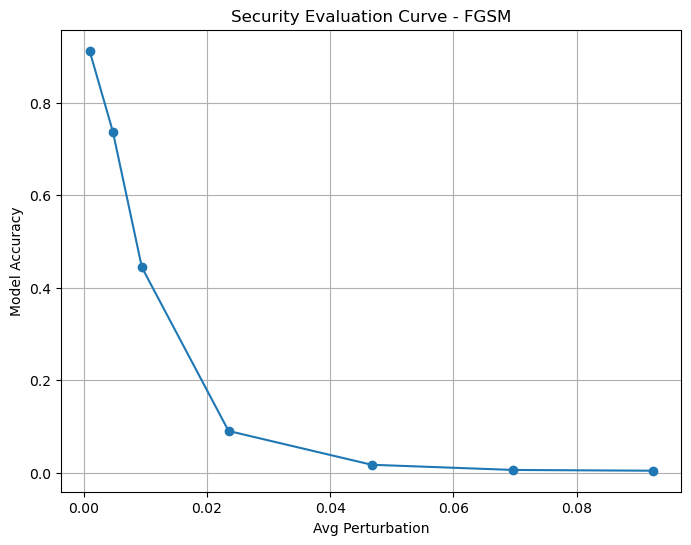

In [8]:
# Non-Targeted FGSM Attack with different epsilon values
epsilon_values = [0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1]
accuracies = []
perturbations = []

# Load pre-saved test set (images and true labels)
x_test, y_test = torch.load('xy_test.pt')

# Prepare directory for saving adversarial samples
save_dir = '../adv_samples/FGSM'
os.makedirs(save_dir, exist_ok=True)

x_test_cpu = x_test.numpy()

for epsilon in epsilon_values:
    # Initialize FGSM attack
    attack = FastGradientMethod(estimator=pytorch_nn1, eps=epsilon, targeted=False)

    # Generate adversarial examples with ART
    x_test_adv_fgsm = attack.generate(x=x_test_cpu)
    x_adv_tensor = torch.from_numpy(x_test_adv_fgsm)

    # Save adversarial samples for reproducibility
    save_path = os.path.join(save_dir, f'fgsm_eps_{epsilon:.3f}.npy')
    np.save(save_path, x_test_adv_fgsm)

    # Batch prediction for efficient GPU inference
    batch_size = 64
    num_samples = x_adv_tensor.size(0)
    preds_list = []

    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            batch = x_adv_tensor[i:i+batch_size].to(device)
            outputs = nn1(batch)
            preds = torch.argmax(outputs, dim=1)
            preds_list.append(preds.cpu())

    # Concatenate predictions
    preds_cpu = torch.cat(preds_list).numpy()

    # Map predicted indices to class names using LABELS
    y_pred_labels = [str(LABELS[idx]).strip() for idx in preds_cpu]
    # Map true indices to class names using idx_to_class
    y_true_labels = [dataset.idx_to_class[int(idx)] for idx in y_test.numpy()]

    # Compute accuracy
    correct = 0
    for pred, true in zip(y_pred_labels, y_true_labels):
        if normalize_string(pred) == normalize_string(true):
            correct += 1
    accuracy = correct / len(y_true_labels)

    # Compute average and max perturbation (L_inf)
    perturbation = torch.mean(torch.abs(x_adv_tensor - x_test)).item()
    L_inf_perturbation = torch.max(torch.abs(x_adv_tensor - x_test)).item()

    print(
        f"Epsilon: {epsilon:.3f}, "
        f"Average perturbation: {perturbation:.4f}, "
        f"L∞: {L_inf_perturbation:.4f}, "
        f"Accuracy: {accuracy * 100:.2f}"
    )

    accuracies.append(accuracy)
    perturbations.append(perturbation)

# Security Evaluation Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(perturbations, accuracies, marker='o', linestyle='-')
plt.xlabel("Avg Perturbation")
plt.ylabel("Model Accuracy")
plt.title("Security Evaluation Curve - FGSM")
plt.grid(True)
plt.show()

### Non-Targeted BIM Attack

PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.001, max_iter: 5, Average perturbation: 0.0009, L∞: 0.0010, Accuracy: 91.28%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.001, max_iter: 10, Average perturbation: 0.0009, L∞: 0.0010, Accuracy: 91.32%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.001, max_iter: 20, Average perturbation: 0.0009, L∞: 0.0010, Accuracy: 91.32%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.005, max_iter: 5, Average perturbation: 0.0039, L∞: 0.0050, Accuracy: 70.64%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.005, max_iter: 10, Average perturbation: 0.0043, L∞: 0.0050, Accuracy: 68.11%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.005, max_iter: 20, Average perturbation: 0.0045, L∞: 0.0050, Accuracy: 66.86%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.010, max_iter: 5, Average perturbation: 0.0072, L∞: 0.0100, Accuracy: 32.64%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.010, max_iter: 10, Average perturbation: 0.0080, L∞: 0.0100, Accuracy: 23.67%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.010, max_iter: 20, Average perturbation: 0.0086, L∞: 0.0100, Accuracy: 20.60%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.025, max_iter: 5, Average perturbation: 0.0149, L∞: 0.0250, Accuracy: 1.08%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.025, max_iter: 10, Average perturbation: 0.0174, L∞: 0.0250, Accuracy: 0.29%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.025, max_iter: 20, Average perturbation: 0.0195, L∞: 0.0250, Accuracy: 0.21%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.050, max_iter: 5, Average perturbation: 0.0247, L∞: 0.0500, Accuracy: 0.08%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.050, max_iter: 10, Average perturbation: 0.0293, L∞: 0.0500, Accuracy: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.050, max_iter: 20, Average perturbation: 0.0333, L∞: 0.0500, Accuracy: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.075, max_iter: 5, Average perturbation: 0.0333, L∞: 0.0750, Accuracy: 0.04%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.075, max_iter: 10, Average perturbation: 0.0392, L∞: 0.0750, Accuracy: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.075, max_iter: 20, Average perturbation: 0.0451, L∞: 0.0750, Accuracy: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.100, max_iter: 5, Average perturbation: 0.0414, L∞: 0.1000, Accuracy: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.100, max_iter: 10, Average perturbation: 0.0487, L∞: 0.1000, Accuracy: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.100, max_iter: 20, Average perturbation: 0.0564, L∞: 0.1000, Accuracy: 0.00%


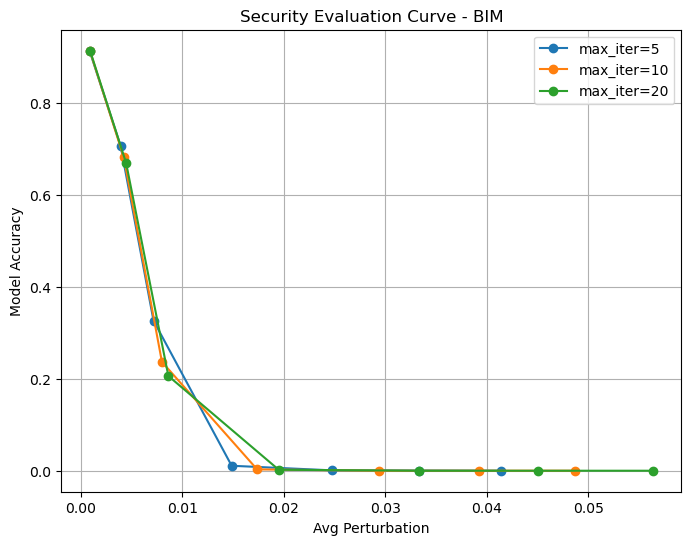

In [9]:
# Non-targeted BIM Attack with different epsilon values
epsilon_values = [0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1]
max_iter_values = [5, 10, 20]

# Load pre-saved test set (images and true labels)
x_test, y_test = torch.load('xy_test.pt')

# Prepare directory for saving adversarial samples
save_dir = '../adv_samples/BIM'
os.makedirs(save_dir, exist_ok=True)

# Prepare results dictionary
results = {k: {"perturbations": [], "accuracies": [], "epsilons": []} for k in max_iter_values}

for epsilon in epsilon_values:
    for max_iter in max_iter_values:
        # Initialize the BIM attack
        attack = BasicIterativeMethod(estimator=pytorch_nn1, eps=epsilon, eps_step=epsilon/5, max_iter=max_iter, targeted=False)

        # Generating adversarial examples
        x_test_cpu = x_test.numpy()
        x_test_adv_bim = attack.generate(x=x_test_cpu)
        x_adv_tensor = torch.from_numpy(x_test_adv_bim)

        # Save adversarial samples for reproducibility
        save_path = os.path.join(save_dir, f'bim_eps_{epsilon:.3f}_iter_{max_iter}.npy')
        np.save(save_path, x_test_adv_bim)

        # Batch prediction for efficient GPU inference
        batch_size = 64
        num_samples = x_adv_tensor.size(0)
        preds_list = []

        with torch.no_grad():
            for i in range(0, num_samples, batch_size):
                batch = x_adv_tensor[i:i+batch_size].to(device)
                outputs = nn1(batch)
                preds = torch.argmax(outputs, dim=1)
                preds_list.append(preds.cpu())

        # Concatenate all predictions
        preds_cpu = torch.cat(preds_list).numpy()

        # Map predicted indices to class names using LABELS
        y_pred_labels = [str(LABELS[idx]).strip() for idx in preds_cpu]
        # Map true indices to class names using idx_to_class
        y_true_labels = [dataset.idx_to_class[int(idx)] for idx in y_test.numpy()]

        # Compute accuracy
        correct = sum(
            normalize_string(pred) == normalize_string(true)
            for pred, true in zip(y_pred_labels, y_true_labels)
        )
        accuracy = correct / len(y_true_labels)
        
        perturbation = torch.mean(torch.abs(x_adv_tensor - x_test)).item()
        L_inf_perturbation = torch.max(torch.abs(x_adv_tensor - x_test)).item()

        print(
            f"Epsilon: {epsilon:.3f}, max_iter: {max_iter}, "
            f"Average perturbation: {perturbation:.4f}, "
            f"L∞: {L_inf_perturbation:.4f}, Accuracy: {accuracy * 100:.2f}%"
        )

        results[max_iter]["perturbations"].append(perturbation)
        results[max_iter]["accuracies"].append(accuracy)
        results[max_iter]["epsilons"].append(epsilon)

# Security Evaluation Curve Plot - BIM
plt.figure(figsize=(8, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green']
for idx, max_iter in enumerate(max_iter_values):
    plt.plot(
        results[max_iter]["perturbations"],
        results[max_iter]["accuracies"],
        marker='o',
        linestyle='-',
        color=colors[idx % len(colors)],
        label=f"max_iter={max_iter}"
    )
plt.xlabel("Avg Perturbation")
plt.ylabel("Model Accuracy")
plt.title("Security Evaluation Curve - BIM")
plt.legend()
plt.grid(True)
plt.show()

### Non-targeted PGD Attack

PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Average perturbation: 0.0009, max_iter: 10, Epsilon: 0.001, L∞: 0.0010, Accuracy: 91.32%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Average perturbation: 0.0043, max_iter: 10, Epsilon: 0.005, L∞: 0.0050, Accuracy: 68.52%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Average perturbation: 0.0082, max_iter: 10, Epsilon: 0.010, L∞: 0.0100, Accuracy: 25.46%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Average perturbation: 0.0181, max_iter: 10, Epsilon: 0.025, L∞: 0.0250, Accuracy: 0.33%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Average perturbation: 0.0320, max_iter: 10, Epsilon: 0.050, L∞: 0.0500, Accuracy: 0.08%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Average perturbation: 0.0447, max_iter: 10, Epsilon: 0.075, L∞: 0.0750, Accuracy: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Average perturbation: 0.0571, max_iter: 10, Epsilon: 0.100, L∞: 0.1000, Accuracy: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Average perturbation: 0.0010, max_iter: 20, Epsilon: 0.001, L∞: 0.0010, Accuracy: 91.32%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Average perturbation: 0.0046, max_iter: 20, Epsilon: 0.005, L∞: 0.0050, Accuracy: 66.82%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Average perturbation: 0.0089, max_iter: 20, Epsilon: 0.010, L∞: 0.0100, Accuracy: 20.93%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Average perturbation: 0.0201, max_iter: 20, Epsilon: 0.025, L∞: 0.0250, Accuracy: 0.25%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Average perturbation: 0.0349, max_iter: 20, Epsilon: 0.050, L∞: 0.0500, Accuracy: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Average perturbation: 0.0479, max_iter: 20, Epsilon: 0.075, L∞: 0.0750, Accuracy: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Average perturbation: 0.0606, max_iter: 20, Epsilon: 0.100, L∞: 0.1000, Accuracy: 0.00%


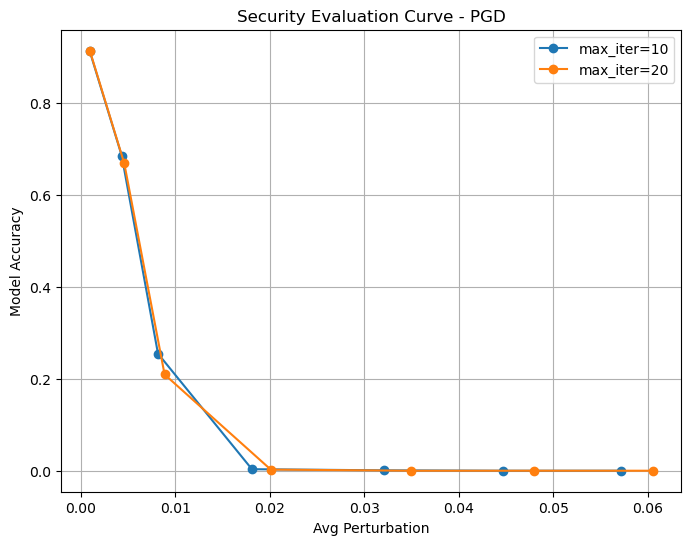

In [10]:
# Non-targeted PGD Attack with different epsilon and max_iter values
epsilon_values = [0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1]
max_iter_values = [10, 20]
num_random_init = 1

# Prepare directory for saving adversarial samples
save_dir = '../adv_samples/PGD'
os.makedirs(save_dir, exist_ok=True)

# Load pre-saved test set (images and true labels)
x_test, y_test = torch.load('xy_test.pt')

# Store results by max_iter
results = {k: {"perturbations": [], "accuracies": [], "epsilons": []} for k in max_iter_values}

for max_iter in max_iter_values:
    for epsilon in epsilon_values:
        # Initialize the PGD attack
        attack = ProjectedGradientDescent(estimator=pytorch_nn1, norm=np.inf, eps=epsilon, eps_step=epsilon/5, max_iter=max_iter, targeted=False, num_random_init=num_random_init)
        
        # Generating adversarial examples
        x_test_cpu = x_test.numpy()
        x_test_adv_pgd = attack.generate(x=x_test_cpu)
        x_adv_tensor = torch.from_numpy(x_test_adv_pgd)
        
        # Save adversarial samples for reproducibility
        save_path = os.path.join(save_dir, f'pgd_eps_{epsilon:.3f}_iter_{max_iter}.npy')
        np.save(save_path, x_test_adv_pgd)
        
        # Batch prediction for efficient GPU inference
        batch_size = 64
        num_samples = x_adv_tensor.size(0)
        preds_list = []
        
        with torch.no_grad():
            for i in range(0, num_samples, batch_size):
                batch = x_adv_tensor[i:i+batch_size].to(device)
                outputs = nn1(batch)
                preds = torch.argmax(outputs, dim=1)
                preds_list.append(preds.cpu())
        
        # Concatenate all predictions
        preds_cpu = torch.cat(preds_list).numpy()
        
        # Map predicted indices to class names using LABELS
        y_pred_labels = [str(LABELS[idx]).strip() for idx in preds_cpu]
        # Map true indices to class names using idx_to_class
        y_true_labels = [dataset.idx_to_class[int(idx)] for idx in y_test.numpy()]
        
        # Compute accuracy
        correct = sum(
            normalize_string(pred) == normalize_string(true)
            for pred, true in zip(y_pred_labels, y_true_labels)
        )
        accuracy = correct / len(y_true_labels)
        
        perturbation = torch.mean(torch.abs(x_adv_tensor - x_test)).item()
        linf_perturbation = torch.max(torch.abs(x_adv_tensor - x_test)).item()
        
        print(
            f"Average perturbation: {perturbation:.4f}, "
            f"max_iter: {max_iter}, Epsilon: {epsilon:.3f}, "
            f"L∞: {linf_perturbation:.4f}, "
            f"Accuracy: {accuracy * 100:.2f}%"
        )
        
        results[max_iter]["perturbations"].append(perturbation)
        results[max_iter]["accuracies"].append(accuracy)
        results[max_iter]["epsilons"].append(epsilon)

# Security Evaluation Curve Plot - PGD
plt.figure(figsize=(8, 6))
colors = ['tab:blue', 'tab:orange']
for idx, max_iter in enumerate(max_iter_values):
    plt.plot(
        results[max_iter]["perturbations"],
        results[max_iter]["accuracies"],
        marker='o',
        linestyle='-',
        color=colors[idx % len(colors)],
        label=f"max_iter={max_iter}"
    )
plt.xlabel("Avg Perturbation")
plt.ylabel("Model Accuracy")
plt.title("Security Evaluation Curve - PGD")
plt.legend()
plt.grid(True)
plt.show()

### Non-targeted DeepFool Attack

Generating DeepFool adversarial examples on 50 random test samples...


DeepFool:   0%|          | 0/50 [00:00<?, ?it/s]


Evaluating predictions on adversarial examples:


100%|██████████| 50/50 [00:00<00:00, 73.42it/s]



DeepFool attack (50 random samples):
    Fooling rate: 16.00%
    Accuracy after attack: 84.00%
    Average L∞ perturbation: 0.00163


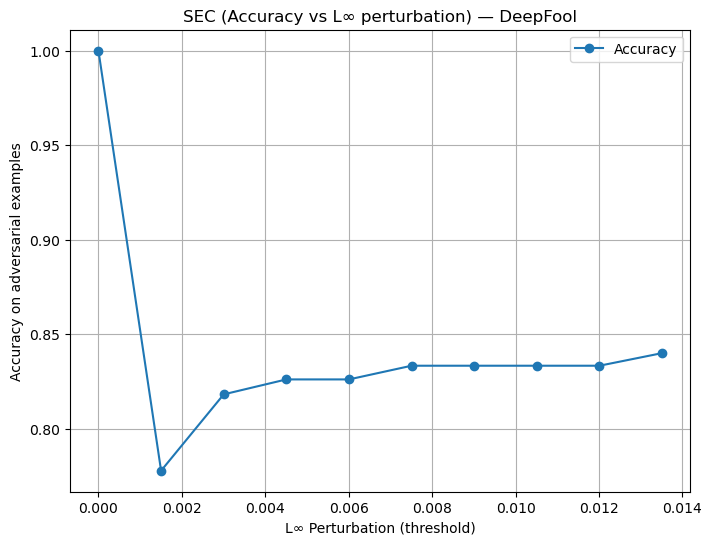

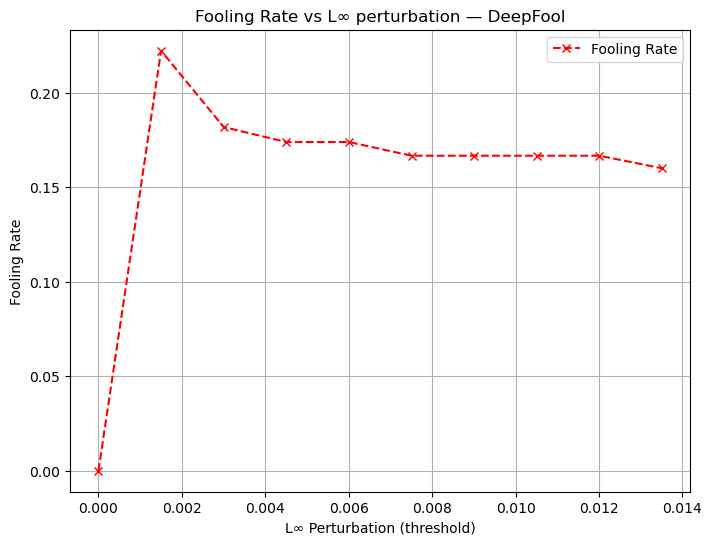

In [11]:
# Fix random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Parameters
epsilon = 0.02         # DeepFool "overshoot"
max_iter = 5           # Limit for speed
nb_grads = 10          # Top-k classes for gradients
subset_size = 50       # Number of random images

# Prepare directory for saving adversarial samples
save_dir = '../adv_samples/DeepFool'
os.makedirs(save_dir, exist_ok=True)

# Load test set (images and true labels)
x_test, y_test = torch.load('xy_test.pt')
x_test_np = x_test.numpy()
y_test_np = y_test.numpy()

# Select random subset and save indices
indices = np.random.choice(len(x_test_np), size=subset_size, replace=False)
np.save(os.path.join(save_dir, 'deepfool_indices.npy'), indices)
x_test_subset = x_test_np[indices]
y_test_subset = y_test_np[indices]

# Map numeric labels to class names
y_true_labels = [dataset.idx_to_class[int(lbl)] for lbl in y_test_subset]

# Initialize DeepFool attack
attack = DeepFool(classifier=pytorch_nn1, epsilon=epsilon, max_iter=max_iter, nb_grads=nb_grads)

# Generate adversarial examples
print(f"Generating DeepFool adversarial examples on {subset_size} random test samples...")
x_test_adv_df = attack.generate(x=x_test_subset)
np.save(os.path.join(save_dir, f'deepfool_eps_{epsilon:.3f}.npy'), x_test_adv_df)

# Evaluate: fooling rate, accuracy, L∞ perturbation only
correct = 0
fooling = 0
total = len(x_test_subset)
linf_perturbations = []
pred_labels = []

print("\nEvaluating predictions on adversarial examples:")
for i in tqdm(range(total)):
    adv_img = torch.tensor(x_test_adv_df[i]).unsqueeze(0).float().to(device)
    with torch.no_grad():
        output = nn1(adv_img)
        pred_idx = output[0].argmax().item()
    pred_label = str(LABELS[pred_idx]).strip()
    pred_labels.append(pred_label)
    true_label = y_true_labels[i]

    if normalize_string(pred_label) == normalize_string(true_label):
        correct += 1
    else:
        fooling += 1

    # L∞ perturbation
    diff = np.abs(x_test_adv_df[i] - x_test_subset[i])
    linf_perturbations.append(np.max(diff))

accuracy = correct / total
fooling_rate = fooling / total
avg_linf = np.mean(linf_perturbations)

print(f"\nDeepFool attack ({subset_size} random samples):")
print(f"    Fooling rate: {fooling_rate*100:.2f}%")
print(f"    Accuracy after attack: {accuracy*100:.2f}%")
print(f"    Average L∞ perturbation: {avg_linf:.5f}")

# SEC and fooling rate vs perturbation
sorted_linf = np.sort(np.array(linf_perturbations))
thresholds = np.linspace(sorted_linf.min(), sorted_linf.max(), 10)
sec_accuracies = []
sec_fooling_rates = []

for thresh in thresholds:
    idxs = np.where(np.array(linf_perturbations) <= thresh)[0]
    if len(idxs) == 0:
        sec_accuracies.append(1.0)
        sec_fooling_rates.append(0.0)
    else:
        n_ok = sum(
            normalize_string(pred_labels[idx]) == normalize_string(y_true_labels[idx])
            for idx in idxs
        )
        sec_accuracies.append(n_ok / len(idxs))
        sec_fooling_rates.append(1.0 - (n_ok / len(idxs)))

# Security Evaluation Curve Plot - DeepFool
plt.figure(figsize=(8, 6))
plt.plot(thresholds, sec_accuracies, marker='o', linestyle='-', label='Accuracy')
plt.xlabel("L∞ Perturbation (threshold)")
plt.ylabel("Accuracy on adversarial examples")
plt.title("SEC (Accuracy vs L∞ perturbation) — DeepFool")
plt.grid(True)
plt.legend()
plt.show()

# Fooling Rate vs L∞ perturbation Plot
plt.figure(figsize=(8, 6))
plt.plot(thresholds, sec_fooling_rates, marker='x', linestyle='--', color='red', label='Fooling Rate')
plt.xlabel("L∞ Perturbation (threshold)")
plt.ylabel("Fooling Rate")
plt.title("Fooling Rate vs L∞ perturbation — DeepFool")
plt.grid(True)
plt.legend()
plt.show()

### Non-targeted Carlini-Wagner (CW) L-Inf Attack

C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 1, init_const: 0.01 | Avg perturbation: 0.0046, Linf: 0.0100, Accuracy: 30.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 1, init_const: 0.1 | Avg perturbation: 0.0046, Linf: 0.0100, Accuracy: 30.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 10, init_const: 0.01 | Avg perturbation: 0.0079, Linf: 0.0200, Accuracy: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 10, init_const: 0.1 | Avg perturbation: 0.0079, Linf: 0.0200, Accuracy: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 20, init_const: 0.01 | Avg perturbation: 0.0079, Linf: 0.0200, Accuracy: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 20, init_const: 0.1 | Avg perturbation: 0.0079, Linf: 0.0200, Accuracy: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 1, init_const: 0.01 | Avg perturbation: 0.0655, Linf: 0.0999, Accuracy: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 1, init_const: 0.1 | Avg perturbation: 0.0655, Linf: 0.0999, Accuracy: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 10, init_const: 0.01 | Avg perturbation: 0.0655, Linf: 0.0999, Accuracy: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 10, init_const: 0.1 | Avg perturbation: 0.0655, Linf: 0.0999, Accuracy: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 20, init_const: 0.01 | Avg perturbation: 0.0655, Linf: 0.0999, Accuracy: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 20, init_const: 0.1 | Avg perturbation: 0.0655, Linf: 0.0999, Accuracy: 0.00%


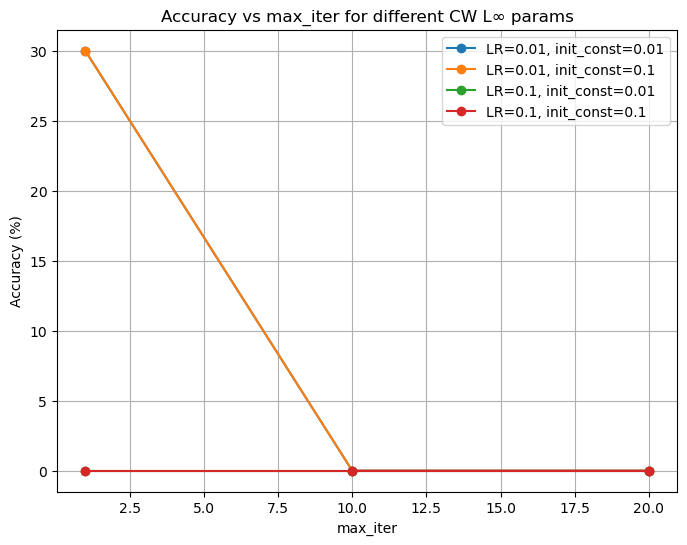

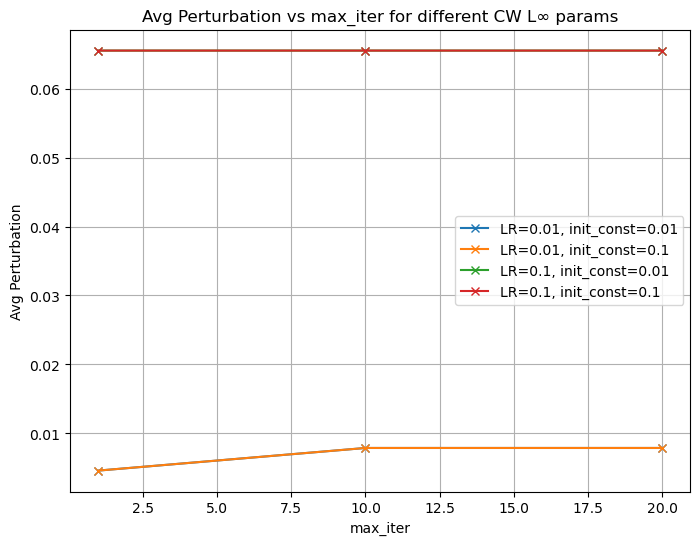

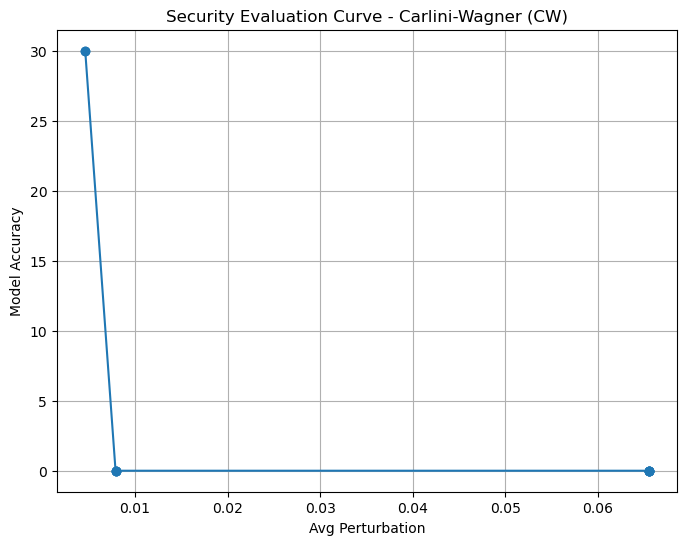

In [15]:
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Parameters
confidence = 0.1
learning_rates = [0.01, 0.1]        # Different learning rates to test
max_iters = [1, 10, 20]             # Typical values for exploration (increase for stronger attack)
initial_consts = [0.01, 0.1]        # Default values for initial constant in CW attack (see CW paper)

# Collect metrics in a list of dicts
results = []
perturbations = []
accuracies = []

# Load pre-saved test set (images and true labels)
x_test, y_test = torch.load('xy_test.pt')

# Prepare directory for saving adversarial samples
save_dir = '../adv_samples/CW'
os.makedirs(save_dir, exist_ok=True)

# Randomly select a reproducible subset of 20 samples for evaluation
subset_size = 20
indices = np.random.choice(len(x_test), size=subset_size, replace=False)
np.save(os.path.join(save_dir, 'cw_indices.npy'), indices)  # Save indices for transferability and reproducibility
x_test_subset = x_test[indices]
y_test_subset = y_test[indices]

# Map true indices to class names for comparison
y_true_labels = [dataset.idx_to_class[int(idx)] for idx in y_test_subset.numpy()]

for lr in learning_rates:
    for max_iter in max_iters:
        for init_const in initial_consts:
            # Initialize Carlini & Wagner L-infinity attack
            attack = CarliniLInfMethod(classifier=pytorch_nn1, confidence=confidence, max_iter=max_iter, learning_rate=lr, initial_const=init_const, targeted=False)
            
            # Generate adversarial examples for the subset
            x_test_cpu = x_test_subset.numpy()
            x_test_adv_cw = attack.generate(x=x_test_cpu)
            x_adv_tensor = torch.from_numpy(x_test_adv_cw)

            # Save adversarial samples for this parameter combination (reproducibility)
            save_path = os.path.join(
                save_dir,
                f'cw_lr_{lr}_maxiter_{max_iter}_initconst_{init_const}.npy'
            )
            np.save(save_path, x_test_adv_cw)

            # Batch predictions for efficient GPU inference
            batch_size = 64
            preds_list = []
            with torch.no_grad():
                for i in range(0, x_adv_tensor.size(0), batch_size):
                    batch = x_adv_tensor[i:i+batch_size].to(device)
                    outputs = nn1(batch)
                    preds = torch.argmax(outputs, dim=1)
                    preds_list.append(preds.cpu())
                    
            preds_cpu = torch.cat(preds_list).numpy()
            y_pred_labels = [str(LABELS[idx]).strip() for idx in preds_cpu]

            # Compute accuracy
            correct = sum(
                normalize_string(pred) == normalize_string(true)
                for pred, true in zip(y_pred_labels, y_true_labels)
            )
            accuracy = correct / len(y_true_labels)
            
            # Compute perturbation metrics
            perturbation = torch.mean(torch.abs(x_adv_tensor - x_test_subset)).item()
            linf_perturbation = torch.max(torch.abs(x_adv_tensor - x_test_subset)).item()

            print(
                f"LR: {lr}, max_iter: {max_iter}, init_const: {init_const} | "
                f"Avg perturbation: {perturbation:.4f}, Linf: {linf_perturbation:.4f}, Accuracy: {accuracy * 100:.2f}%"
            )

            # Collect parameters and results for plotting
            results.append({
                "learning_rate": lr,
                "max_iter": max_iter,
                "initial_const": init_const,
                "accuracy": accuracy * 100,
                "average_perturbation": perturbation,
                "linf": linf_perturbation
            })

            # Collect for security evaluation curve
            perturbations.append(perturbation)
            accuracies.append(accuracy * 100)

# Convert to DataFrame for easy plotting
df = pd.DataFrame(results)

# Accuracy vs max_iter for different CW L∞ params Plot
plt.figure(figsize=(8, 6))
for (lr, init_const), group in df.groupby(['learning_rate', 'initial_const']):
    plt.plot(group["max_iter"], group["accuracy"], marker='o', label=f"LR={lr}, init_const={init_const}")
plt.xlabel("max_iter")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs max_iter for different CW L∞ params")
plt.legend()
plt.grid(True)
plt.show()

# Average Perturbation vs max_iter for different CW L∞ params Plot
plt.figure(figsize=(8, 6))
for (lr, init_const), group in df.groupby(['learning_rate', 'initial_const']):
    plt.plot(group["max_iter"], group["average_perturbation"], marker='x', label=f"LR={lr}, init_const={init_const}")
plt.xlabel("max_iter")
plt.ylabel("Avg Perturbation")
plt.title("Avg Perturbation vs max_iter for different CW L∞ params")
plt.legend()
plt.grid(True)
plt.show()

# Security Evaluation Curve Plot - CW
plt.figure(figsize=(8, 6))
plt.plot(perturbations, accuracies, marker='o', linestyle='-')
plt.xlabel("Avg Perturbation")
plt.ylabel("Model Accuracy")
plt.title("Security Evaluation Curve - Carlini-Wagner (CW)")
plt.grid(True)
plt.show()

### Non-targeted Carlini-Wagner (CW) L2 Attack

C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 1, init_const: 0.01 | Avg L2: 0.5163, Max L2: 1.7780, Accuracy: 35.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 1, init_const: 0.1 | Avg L2: 0.9041, Max L2: 2.2214, Accuracy: 5.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 10, init_const: 0.01 | Avg L2: 0.5974, Max L2: 1.2304, Accuracy: 0.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 10, init_const: 0.1 | Avg L2: 0.6083, Max L2: 1.2958, Accuracy: 0.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 20, init_const: 0.01 | Avg L2: 0.5898, Max L2: 1.2318, Accuracy: 0.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 20, init_const: 0.1 | Avg L2: 0.6038, Max L2: 1.2956, Accuracy: 0.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 1, init_const: 0.01 | Avg L2: 0.6941, Max L2: 2.2214, Accuracy: 15.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 1, init_const: 0.1 | Avg L2: 1.0383, Max L2: 2.7747, Accuracy: 0.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 10, init_const: 0.01 | Avg L2: 0.6015, Max L2: 1.2428, Accuracy: 0.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 10, init_const: 0.1 | Avg L2: 0.6216, Max L2: 1.4073, Accuracy: 0.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 20, init_const: 0.01 | Avg L2: 0.5959, Max L2: 1.2393, Accuracy: 0.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 20, init_const: 0.1 | Avg L2: 0.6221, Max L2: 1.4063, Accuracy: 0.00%


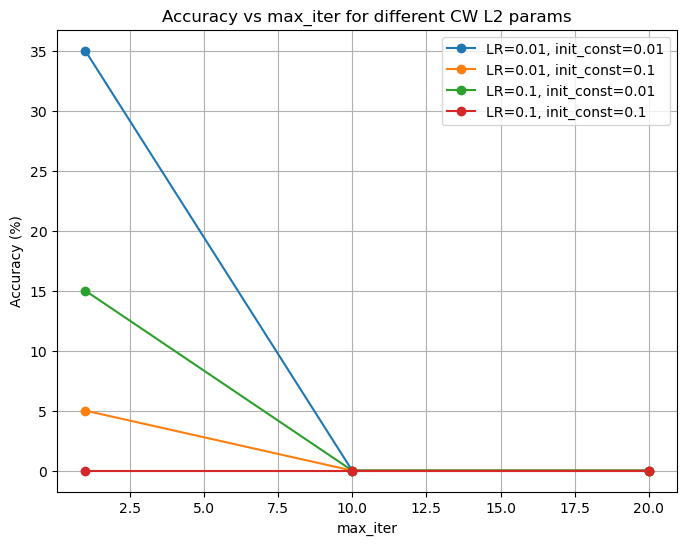

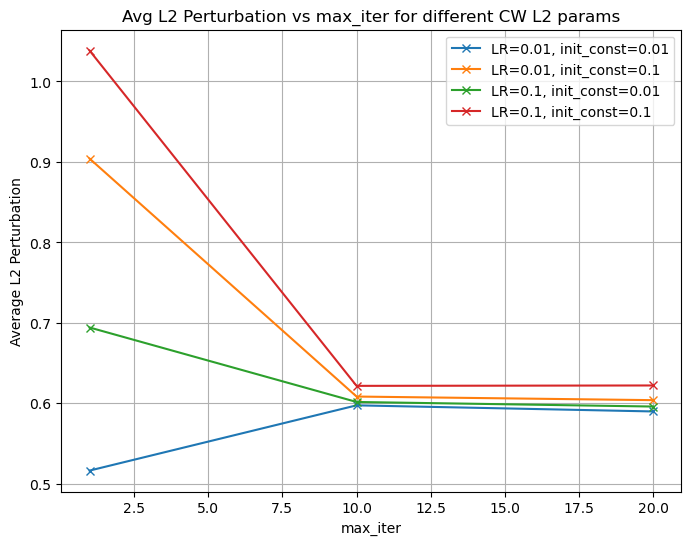

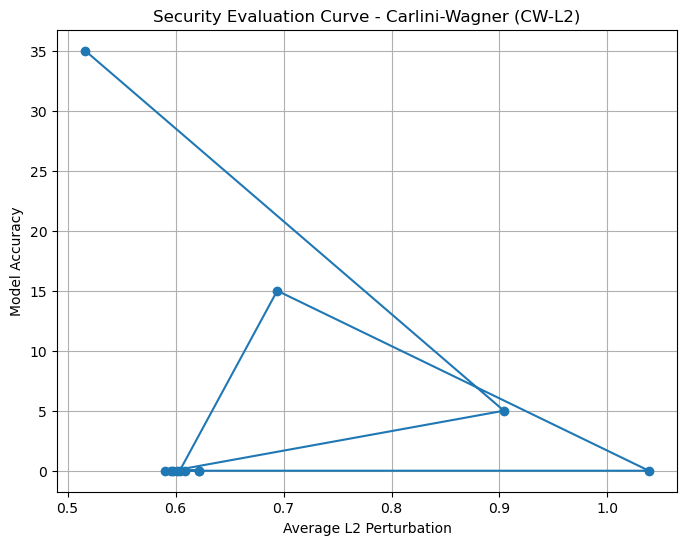

In [8]:
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Parameters
confidence = 0.1
learning_rates = [0.01, 0.1]
max_iters = [1, 10, 20]
initial_consts = [0.01, 0.1]

results = []
perturbations = []
accuracies = []

# Load pre-saved test set (images and true labels)
x_test, y_test = torch.load('xy_test.pt')

# Prepare directory for saving adversarial samples
save_dir = '../adv_samples/CW-L2'
os.makedirs(save_dir, exist_ok=True)

# Randomly select a reproducible subset of 20 samples for evaluation
subset_size = 20
indices = np.random.choice(len(x_test), size=subset_size, replace=False)
np.save(os.path.join(save_dir, 'cw_L2_indices.npy'), indices)  # Save indices for transferability and reproducibility
x_test_subset = x_test[indices]
y_test_subset = y_test[indices]

# Map true indices to class names for comparison
y_true_labels = [dataset.idx_to_class[int(idx)] for idx in y_test_subset.numpy()]

for lr in learning_rates:
    for max_iter in max_iters:
        for init_const in initial_consts:
            # Initialize Carlini & Wagner L2 attack (untargeted)
            attack = CarliniL2Method(classifier=pytorch_nn1, confidence=confidence, max_iter=max_iter, learning_rate=lr, binary_search_steps=9, initial_const=init_const, targeted=False)
            
            # Generate adversarial examples for the subset
            x_test_cpu = x_test_subset.numpy()
            x_test_adv_cw = attack.generate(x=x_test_cpu)
            x_adv_tensor = torch.from_numpy(x_test_adv_cw)

            # Save adversarial samples for this parameter combination (reproducibility)
            save_path = os.path.join(
                save_dir,
                f'cw_l2_lr_{lr}_maxiter_{max_iter}_initconst_{init_const}.npy'
            )
            np.save(save_path, x_test_adv_cw)

            # Batch predictions for efficient GPU inference
            batch_size = 64
            preds_list = []
            with torch.no_grad():
                for i in range(0, x_adv_tensor.size(0), batch_size):
                    batch = x_adv_tensor[i:i+batch_size].to(device)
                    outputs = nn1(batch)
                    preds = torch.argmax(outputs, dim=1)
                    preds_list.append(preds.cpu())
                    
            preds_cpu = torch.cat(preds_list).numpy()
            y_pred_labels = [str(LABELS[idx]).strip() for idx in preds_cpu]

            # Compute accuracy (untargeted: label ≠ true label)
            correct = sum(
                normalize_string(pred) == normalize_string(true)
                for pred, true in zip(y_pred_labels, y_true_labels)
            )
            accuracy = correct / len(y_true_labels)

            # Compute L2 perturbation metrics
            diff = x_adv_tensor - x_test_subset  # (batch_size, C, H, W)
            perturbation_l2 = torch.norm(diff.view(diff.size(0), -1), p=2, dim=1)
            avg_l2 = perturbation_l2.mean().item()
            max_l2 = perturbation_l2.max().item()

            print(
                f"LR: {lr}, max_iter: {max_iter}, init_const: {init_const} | "
                f"Avg L2: {avg_l2:.4f}, Max L2: {max_l2:.4f}, Accuracy: {accuracy * 100:.2f}%"
            )

            # Collect parameters and results for plotting
            results.append({
                "learning_rate": lr,
                "max_iter": max_iter,
                "initial_const": init_const,
                "accuracy": accuracy * 100,
                "average_l2": avg_l2,
                "max_l2": max_l2
            })

            # Collect for security evaluation curve
            perturbations.append(avg_l2)
            accuracies.append(accuracy * 100)

# Convert to DataFrame for easy plotting
df = pd.DataFrame(results)

# Accuracy vs max_iter for different CW L2 params Plot
plt.figure(figsize=(8, 6))
for (lr, init_const), group in df.groupby(['learning_rate', 'initial_const']):
    plt.plot(group["max_iter"], group["accuracy"], marker='o', label=f"LR={lr}, init_const={init_const}")
plt.xlabel("max_iter")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs max_iter for different CW L2 params")
plt.legend()
plt.grid(True)
plt.show()

# Average L2 Perturbation vs max_iter for different CW L2 params Plot
plt.figure(figsize=(8, 6))
for (lr, init_const), group in df.groupby(['learning_rate', 'initial_const']):
    plt.plot(group["max_iter"], group["average_l2"], marker='x', label=f"LR={lr}, init_const={init_const}")
plt.xlabel("max_iter")
plt.ylabel("Average L2 Perturbation")
plt.title("Avg L2 Perturbation vs max_iter for different CW L2 params")
plt.legend()
plt.grid(True)
plt.show()

# Security Evaluation Curve Plot - CW-L2
plt.figure(figsize=(8, 6))
plt.plot(perturbations, accuracies, marker='o', linestyle='-')
plt.xlabel("Average L2 Perturbation")
plt.ylabel("Model Accuracy")
plt.title("Security Evaluation Curve - Carlini-Wagner (CW-L2)")
plt.grid(True)
plt.show()

## Targeted Attacks (Error-Specific)

### Targeted FSGM Attack

Epsilon: 0.001, Average perturbation: 0.0009, L∞: 0.0010, Targeted Success Rate: 0.00%
Epsilon: 0.005, Average perturbation: 0.0047, L∞: 0.0050, Targeted Success Rate: 0.00%
Epsilon: 0.010, Average perturbation: 0.0094, L∞: 0.0100, Targeted Success Rate: 0.21%
Epsilon: 0.025, Average perturbation: 0.0235, L∞: 0.0250, Targeted Success Rate: 5.23%
Epsilon: 0.050, Average perturbation: 0.0467, L∞: 0.0500, Targeted Success Rate: 11.71%
Epsilon: 0.075, Average perturbation: 0.0697, L∞: 0.0750, Targeted Success Rate: 14.29%
Epsilon: 0.100, Average perturbation: 0.0924, L∞: 0.1000, Targeted Success Rate: 14.45%


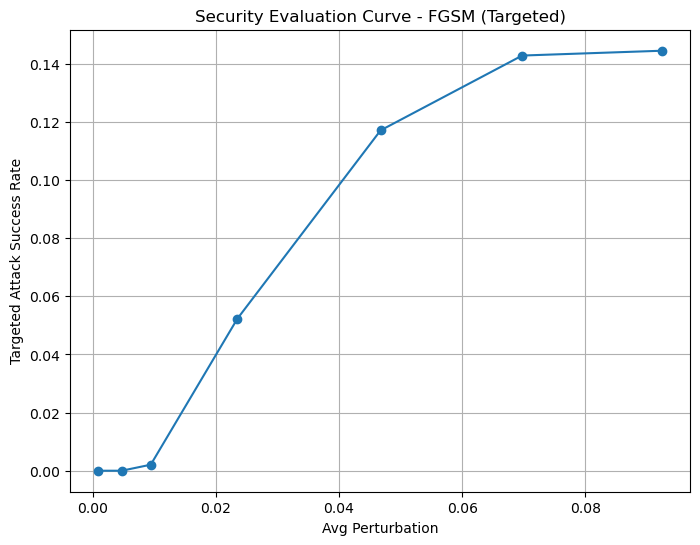

In [9]:
# Targeted FGSM Attack with different epsilon values
epsilon_values = [0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1]
accuracies = []
perturbations = []

# Load pre-saved test set (images and true labels)
x_test, y_test = torch.load('xy_test.pt')

# Prepare directory for saving adversarial samples
save_dir = '../adv_samples/FGSM_targeted'
os.makedirs(save_dir, exist_ok=True)

# Define target labels (next class, cyclic)
num_classes = len(LABELS)
target_labels = (y_test + 1) % num_classes
y_target_onehot = np.eye(num_classes)[target_labels.numpy()]  # (N, num_classes)


for epsilon in epsilon_values:
    # Initialize targeted FGSM attack
    attack = FastGradientMethod(estimator=pytorch_nn1, eps=epsilon, targeted=True)
    x_test_cpu = x_test.numpy()
    
    # Generate targeted adversarial examples
    x_test_adv_fgsm = attack.generate(x=x_test_cpu, y=y_target_onehot)
    x_adv_tensor = torch.from_numpy(x_test_adv_fgsm)

    # Save adversarial samples for reproducibility
    save_path = os.path.join(save_dir, f'fgsm_targeted_eps_{epsilon:.3f}.npy')
    np.save(save_path, x_test_adv_fgsm)

    # Batch prediction for efficient GPU inference
    batch_size = 64
    num_samples = x_adv_tensor.size(0)
    preds_list = []

    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            batch = x_adv_tensor[i:i+batch_size].to(device)
            outputs = nn1(batch)
            preds = torch.argmax(outputs, dim=1)
            preds_list.append(preds.cpu())

    # Concatenate all predictions
    preds_cpu = torch.cat(preds_list).numpy()
    y_pred_labels = [str(LABELS[idx]).strip() for idx in preds_cpu]
    y_target_labels = [str(LABELS[idx]).strip() for idx in target_labels.numpy()]

    # Success rate: compare predictions to targets
    correct = sum(
        normalize_string(pred) == normalize_string(true)
        for pred, true in zip(y_pred_labels, y_target_labels)
    )
    accuracy = correct / len(y_target_labels)
    
    perturbation = torch.mean(torch.abs(x_adv_tensor - x_test)).item()
    L_inf_perturbation = torch.max(torch.abs(x_adv_tensor - x_test)).item()

    print(
        f"Epsilon: {epsilon:.3f}, Average perturbation: {perturbation:.4f}, "
        f"L∞: {L_inf_perturbation:.4f}, Targeted Success Rate: {accuracy * 100:.2f}%"
    )

    accuracies.append(accuracy)
    perturbations.append(perturbation)

# Security Evaluation Curve Plot - FGSM (Targeted)
plt.figure(figsize=(8, 6))
plt.plot(perturbations, accuracies, marker='o', linestyle='-')
plt.xlabel("Avg Perturbation")
plt.ylabel("Targeted Attack Success Rate")
plt.title("Security Evaluation Curve - FGSM (Targeted)")
plt.grid(True)
plt.show()

### Targeted BIM Attack

PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.001, max_iter: 5, Avg perturbation: 0.0009, L∞: 0.0010, Targeted Success Rate: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.001, max_iter: 10, Avg perturbation: 0.0009, L∞: 0.0010, Targeted Success Rate: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.001, max_iter: 20, Avg perturbation: 0.0009, L∞: 0.0010, Targeted Success Rate: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.005, max_iter: 5, Avg perturbation: 0.0039, L∞: 0.0050, Targeted Success Rate: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.005, max_iter: 10, Avg perturbation: 0.0043, L∞: 0.0050, Targeted Success Rate: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.005, max_iter: 20, Avg perturbation: 0.0045, L∞: 0.0050, Targeted Success Rate: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.010, max_iter: 5, Avg perturbation: 0.0071, L∞: 0.0100, Targeted Success Rate: 0.79%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.010, max_iter: 10, Avg perturbation: 0.0080, L∞: 0.0100, Targeted Success Rate: 1.25%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.010, max_iter: 20, Avg perturbation: 0.0086, L∞: 0.0100, Targeted Success Rate: 1.41%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.025, max_iter: 5, Avg perturbation: 0.0146, L∞: 0.0250, Targeted Success Rate: 28.45%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.025, max_iter: 10, Avg perturbation: 0.0172, L∞: 0.0250, Targeted Success Rate: 56.48%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.025, max_iter: 20, Avg perturbation: 0.0193, L∞: 0.0250, Targeted Success Rate: 68.19%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.050, max_iter: 5, Avg perturbation: 0.0241, L∞: 0.0500, Targeted Success Rate: 84.43%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.050, max_iter: 10, Avg perturbation: 0.0283, L∞: 0.0500, Targeted Success Rate: 98.42%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.050, max_iter: 20, Avg perturbation: 0.0323, L∞: 0.0500, Targeted Success Rate: 99.63%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.075, max_iter: 5, Avg perturbation: 0.0321, L∞: 0.0750, Targeted Success Rate: 96.72%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.075, max_iter: 10, Avg perturbation: 0.0375, L∞: 0.0750, Targeted Success Rate: 99.88%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.075, max_iter: 20, Avg perturbation: 0.0436, L∞: 0.0750, Targeted Success Rate: 100.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.100, max_iter: 5, Avg perturbation: 0.0398, L∞: 0.1000, Targeted Success Rate: 98.46%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.100, max_iter: 10, Avg perturbation: 0.0466, L∞: 0.1000, Targeted Success Rate: 100.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.100, max_iter: 20, Avg perturbation: 0.0548, L∞: 0.1000, Targeted Success Rate: 100.00%


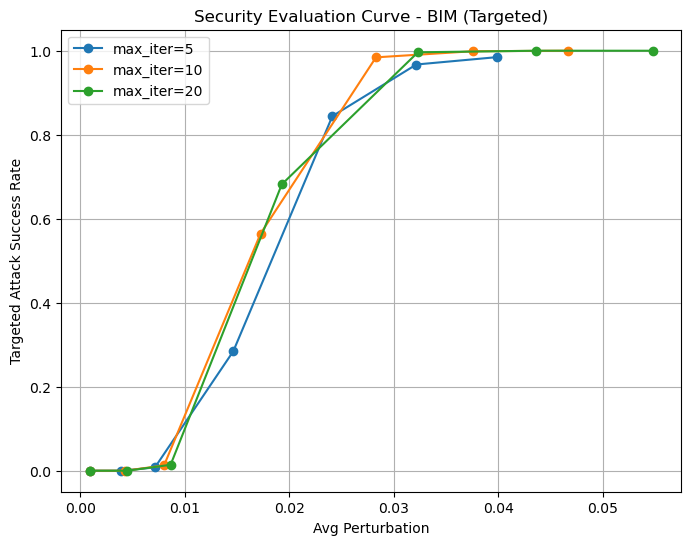

In [16]:
# Targeted BIM Attack with different epsilon and max_iter values
epsilon_values = [0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1]
max_iter_values = [5, 10, 20]

# Load pre-saved test set (images and true labels)
x_test, y_test = torch.load('xy_test.pt')

# Prepare directory for saving adversarial samples
save_dir = '../adv_samples/BIM_targeted'
os.makedirs(save_dir, exist_ok=True)

# Define target labels (next class, cyclic)
num_classes = len(LABELS)
target_labels = (y_test + 1) % num_classes
y_target_onehot = np.eye(num_classes)[target_labels.numpy()]  # (N, num_classes)

# Store results for plotting
results = {k: {"perturbations": [], "accuracies": [], "epsilons": []} for k in max_iter_values}

for epsilon in epsilon_values:
    for max_iter in max_iter_values:
        # Initialize the targeted BIM attack
        attack = BasicIterativeMethod(estimator=pytorch_nn1, eps=epsilon, eps_step=epsilon/5, max_iter=max_iter, targeted=True)
        
        # Generate targeted adversarial examples
        x_test_cpu = x_test.numpy()
        x_test_adv_bim = attack.generate(x=x_test_cpu, y=y_target_onehot)
        x_adv_tensor = torch.from_numpy(x_test_adv_bim)

        # Save adversarial samples for this epsilon and max_iter
        save_path = os.path.join(save_dir, f'bim_targeted_eps_{epsilon:.3f}_iter_{max_iter}.npy')
        np.save(save_path, x_test_adv_bim)

        # Batch predictions for efficient GPU inference
        batch_size = 64
        num_samples = x_adv_tensor.size(0)
        preds_list = []

        with torch.no_grad():
            for i in range(0, num_samples, batch_size):
                batch = x_adv_tensor[i:i+batch_size].to(device)
                outputs = nn1(batch)
                preds = torch.argmax(outputs, dim=1)
                preds_list.append(preds.cpu())

        preds_cpu = torch.cat(preds_list).numpy()
        y_pred_labels = [str(LABELS[idx]).strip() for idx in preds_cpu]
        y_target_labels = [str(LABELS[idx]).strip() for idx in target_labels.numpy()]

        # Compare predictions to target labels
        correct = sum(
            normalize_string(pred) == normalize_string(true)
            for pred, true in zip(y_pred_labels, y_target_labels)
        )
        accuracy = correct / len(y_target_labels)
        
        perturbation = torch.mean(torch.abs(x_adv_tensor - x_test)).item()
        L_inf_perturbation = torch.max(torch.abs(x_adv_tensor - x_test)).item()

        print(
            f"Epsilon: {epsilon:.3f}, max_iter: {max_iter}, "
            f"Avg perturbation: {perturbation:.4f}, "
            f"L∞: {L_inf_perturbation:.4f}, Targeted Success Rate: {accuracy * 100:.2f}%"
        )

        results[max_iter]["perturbations"].append(perturbation)
        results[max_iter]["accuracies"].append(accuracy)
        results[max_iter]["epsilons"].append(epsilon)

# Security Evaluation Curve Plot - BIM (Targeted)
plt.figure(figsize=(8, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green']
for idx, max_iter in enumerate(max_iter_values):
    plt.plot(
        results[max_iter]["perturbations"],
        results[max_iter]["accuracies"],
        marker='o',
        linestyle='-',
        color=colors[idx % len(colors)],
        label=f"max_iter={max_iter}"
    )
plt.xlabel("Avg Perturbation")
plt.ylabel("Targeted Attack Success Rate")
plt.title("Security Evaluation Curve - BIM (Targeted)")
plt.legend()
plt.grid(True)
plt.show()

### Targeted PGD Attack

PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.001, max_iter: 10, Avg perturbation: 0.0009, L∞: 0.0010, Targeted Success Rate: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.005, max_iter: 10, Avg perturbation: 0.0043, L∞: 0.0050, Targeted Success Rate: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.010, max_iter: 10, Avg perturbation: 0.0082, L∞: 0.0100, Targeted Success Rate: 1.12%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.025, max_iter: 10, Avg perturbation: 0.0180, L∞: 0.0250, Targeted Success Rate: 51.25%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.050, max_iter: 10, Avg perturbation: 0.0315, L∞: 0.0500, Targeted Success Rate: 97.09%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.075, max_iter: 10, Avg perturbation: 0.0440, L∞: 0.0750, Targeted Success Rate: 99.71%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.100, max_iter: 10, Avg perturbation: 0.0563, L∞: 0.1000, Targeted Success Rate: 99.88%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.001, max_iter: 20, Avg perturbation: 0.0010, L∞: 0.0010, Targeted Success Rate: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.005, max_iter: 20, Avg perturbation: 0.0046, L∞: 0.0050, Targeted Success Rate: 0.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.010, max_iter: 20, Avg perturbation: 0.0089, L∞: 0.0100, Targeted Success Rate: 1.37%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.025, max_iter: 20, Avg perturbation: 0.0199, L∞: 0.0250, Targeted Success Rate: 67.23%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.050, max_iter: 20, Avg perturbation: 0.0342, L∞: 0.0500, Targeted Success Rate: 99.42%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.075, max_iter: 20, Avg perturbation: 0.0470, L∞: 0.0750, Targeted Success Rate: 100.00%


PGD - Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Epsilon: 0.100, max_iter: 20, Avg perturbation: 0.0596, L∞: 0.1000, Targeted Success Rate: 100.00%


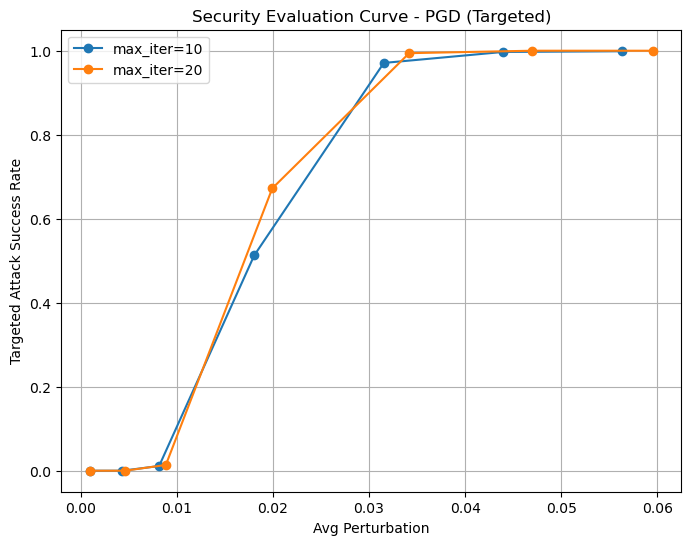

In [17]:
# Targeted PGD Attack with different epsilon and max_iter values
epsilon_values = [0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1]
max_iter_values = [10, 20]
num_random_init = 1

# Load pre-saved test set (images and true labels)
x_test, y_test = torch.load('xy_test.pt')

# Prepare directory for saving adversarial samples
save_dir = '../adv_samples/PGD_targeted'
os.makedirs(save_dir, exist_ok=True)

# Define target labels (next class, cyclic)
num_classes = len(LABELS)
target_labels = (y_test + 1) % num_classes
y_target_onehot = np.eye(num_classes)[target_labels.numpy()]  # (N, num_classes)

# Store results by max_iter for plotting
results = {k: {"perturbations": [], "accuracies": [], "epsilons": []} for k in max_iter_values}

for max_iter in max_iter_values:
    for epsilon in epsilon_values:
        # Initialize the targeted PGD attack
        attack = ProjectedGradientDescent(estimator=pytorch_nn1, norm=np.inf, eps=epsilon, eps_step=epsilon/5, max_iter=max_iter, targeted=True, num_random_init=num_random_init)
        
        # Generate targeted adversarial examples
        x_test_cpu = x_test.numpy()
        x_test_adv_pgd = attack.generate(x=x_test_cpu, y=y_target_onehot)
        x_adv_tensor = torch.from_numpy(x_test_adv_pgd)

        # Save adversarial samples for this epsilon and max_iter
        save_path = os.path.join(save_dir, f'pgd_targeted_eps_{epsilon:.3f}_iter_{max_iter}.npy')
        np.save(save_path, x_test_adv_pgd)

        # Batch predictions for efficient GPU inference
        batch_size = 64
        num_samples = x_adv_tensor.size(0)
        preds_list = []
        
        with torch.no_grad():
            for i in range(0, num_samples, batch_size):
                batch = x_adv_tensor[i:i+batch_size].to(device)
                outputs = nn1(batch)
                preds = torch.argmax(outputs, dim=1)
                preds_list.append(preds.cpu())
                
        preds_cpu = torch.cat(preds_list).numpy()
        y_pred_labels = [str(LABELS[idx]).strip() for idx in preds_cpu]
        y_target_labels = [str(LABELS[idx]).strip() for idx in target_labels.numpy()]

        # Compare to target labels for targeted attack success rate
        correct = sum(
            normalize_string(pred) == normalize_string(true)
            for pred, true in zip(y_pred_labels, y_target_labels)
        )
        accuracy = correct / len(y_target_labels)
        
        perturbation = torch.mean(torch.abs(x_adv_tensor - x_test)).item()
        linf_perturbation = torch.max(torch.abs(x_adv_tensor - x_test)).item()

        print(
            f"Epsilon: {epsilon:.3f}, max_iter: {max_iter}, "
            f"Avg perturbation: {perturbation:.4f}, "
            f"L∞: {linf_perturbation:.4f}, Targeted Success Rate: {accuracy * 100:.2f}%"
        )

        results[max_iter]["perturbations"].append(perturbation)
        results[max_iter]["accuracies"].append(accuracy)
        results[max_iter]["epsilons"].append(epsilon)

# Security Evaluation Curve Plot - PGD (Targeted)
plt.figure(figsize=(8, 6))
colors = ['tab:blue', 'tab:orange']
for idx, max_iter in enumerate(max_iter_values):
    plt.plot(
        results[max_iter]["perturbations"],
        results[max_iter]["accuracies"],
        marker='o',
        linestyle='-',
        color=colors[idx % len(colors)],
        label=f"max_iter={max_iter}"
    )
plt.xlabel("Avg Perturbation")
plt.ylabel("Targeted Attack Success Rate")
plt.title("Security Evaluation Curve - PGD (Targeted)")
plt.legend()
plt.grid(True)
plt.show()

### Targeted Carlini-Wagner (CW) Attack

#### L_Inf Method

C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 1, init_const: 0.01 | Avg perturbation: 0.0066, Linf: 0.0100, Targeted Success Rate: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 1, init_const: 0.1 | Avg perturbation: 0.0066, Linf: 0.0100, Targeted Success Rate: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 10, init_const: 0.01 | Avg perturbation: 0.0005, Linf: 0.0156, Targeted Success Rate: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 10, init_const: 0.1 | Avg perturbation: 0.0005, Linf: 0.0157, Targeted Success Rate: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 20, init_const: 0.01 | Avg perturbation: 0.0000, Linf: 0.0000, Targeted Success Rate: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 20, init_const: 0.1 | Avg perturbation: 0.0000, Linf: 0.0000, Targeted Success Rate: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 1, init_const: 0.01 | Avg perturbation: 0.0484, Linf: 0.0999, Targeted Success Rate: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 1, init_const: 0.1 | Avg perturbation: 0.0484, Linf: 0.0999, Targeted Success Rate: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 10, init_const: 0.01 | Avg perturbation: 0.0000, Linf: 0.0000, Targeted Success Rate: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 10, init_const: 0.1 | Avg perturbation: 0.0000, Linf: 0.0000, Targeted Success Rate: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 20, init_const: 0.01 | Avg perturbation: 0.0000, Linf: 0.0000, Targeted Success Rate: 0.00%


C&W L_inf:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 20, init_const: 0.1 | Avg perturbation: 0.0000, Linf: 0.0000, Targeted Success Rate: 0.00%


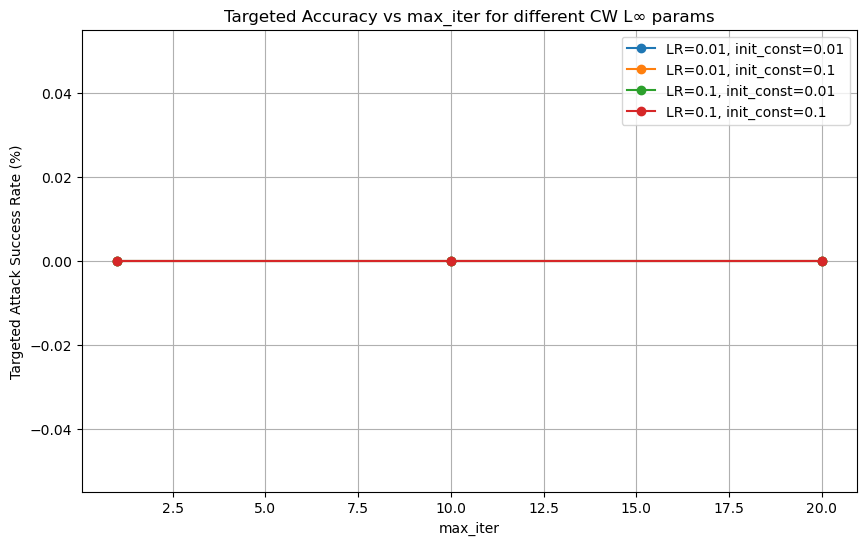

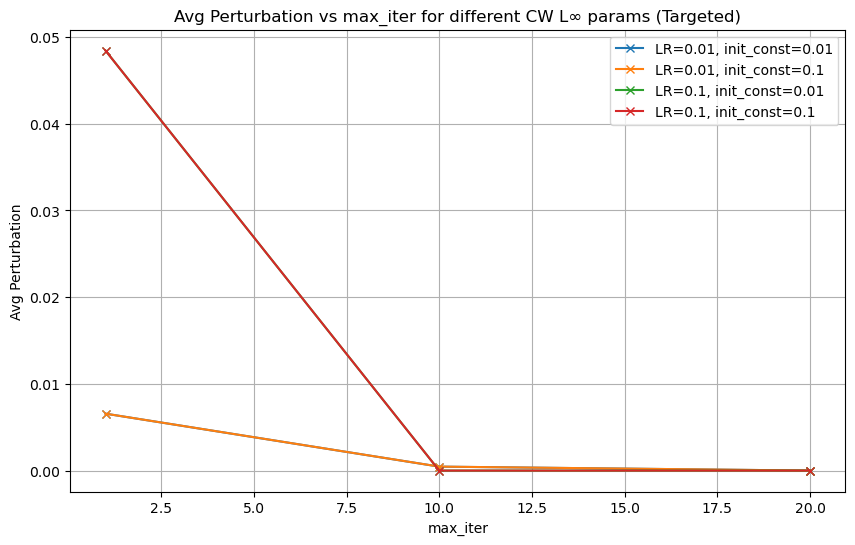

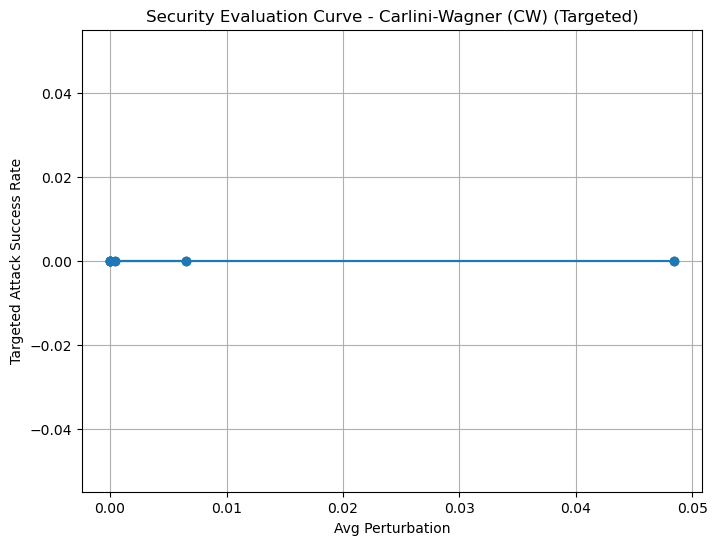

In [11]:
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Targeted Carlini & Wagner L∞ Attack
confidence = 0.1
learning_rates = [0.01, 0.1]        # Different learning rates to test
max_iters = [1, 10, 20]             # To achieve a good trade-off between accuracy and perturbation, set max_iter to 100 (to speed up the attack reduce it)
initial_consts = [0.01, 0.1]        # Default values for initial constant in CW attack (CW 2017)
results = []                        # Collect metrics in a list of dicts
perturbations = []
accuracies = []

# Load pre-saved test set (images and true labels)
x_test, y_test = torch.load('xy_test.pt')

# Prepare directory for saving adversarial samples
save_dir = '../adv_samples/CW_LInf_targeted'
os.makedirs(save_dir, exist_ok=True)

# Randomly select a reproducible subset of 20 samples for evaluation
subset_size = 20
indices = np.random.choice(len(x_test), size=subset_size, replace=False)
np.save(os.path.join(save_dir, 'cw_Linf_targeted_indices.npy'), indices)  # Save indices for transferability/reproducibility
x_test_subset = x_test[indices]
y_true_label = y_test[indices]

# Define target labels (next class, cyclic)
num_classes = len(LABELS)
target_labels = (y_true_label + 1) % num_classes
y_target_onehot = np.eye(num_classes)[target_labels.numpy()]

for lr in learning_rates:
    for max_iter in max_iters:
        for init_const in initial_consts:
            # Initialize targeted Carlini & Wagner L∞ attack
            attack = CarliniLInfMethod(classifier=pytorch_nn1, confidence=confidence, max_iter=max_iter, learning_rate=lr, initial_const=init_const, targeted=True)
            
            # Generate targeted adversarial examples
            x_test_cpu = x_test_subset.numpy()
            x_test_adv_cw = attack.generate(x=x_test_cpu, y=y_target_onehot)
            x_adv_tensor = torch.from_numpy(x_test_adv_cw)

            # Save adversarial samples for this parameter combination
            save_path = os.path.join(
                save_dir,
                f'cw_Linf_targeted_lr_{lr}_maxiter_{max_iter}_initconst_{init_const}.npy'
            )
            np.save(save_path, x_test_adv_cw)

            # Batch predictions for efficient GPU inference
            batch_size = 64
            preds_list = []
            with torch.no_grad():
                for i in range(0, x_adv_tensor.size(0), batch_size):
                    batch = x_adv_tensor[i:i+batch_size].to(device)
                    outputs = nn1(batch)
                    preds = torch.argmax(outputs, dim=1)
                    preds_list.append(preds.cpu())
                    
            preds_cpu = torch.cat(preds_list).numpy()
            y_pred_labels = [str(LABELS[idx]).strip() for idx in preds_cpu]
            y_target_labels = [str(LABELS[idx]).strip() for idx in target_labels.numpy()]

            # Compute targeted attack success rate
            correct = sum(
                normalize_string(pred) == normalize_string(true)
                for pred, true in zip(y_pred_labels, y_target_labels)
            )
            accuracy = correct / len(y_target_labels)
            
            perturbation = torch.mean(torch.abs(x_adv_tensor - x_test_subset)).item()
            linf_perturbation = torch.max(torch.abs(x_adv_tensor - x_test_subset)).item()

            print(
                f"LR: {lr}, max_iter: {max_iter}, init_const: {init_const} | "
                f"Avg perturbation: {perturbation:.4f}, Linf: {linf_perturbation:.4f}, Targeted Success Rate: {accuracy * 100:.2f}%"
            )

            # Collect parameters and results for plotting
            results.append({
                "learning_rate": lr,
                "max_iter": max_iter,
                "initial_const": init_const,
                "accuracy": accuracy * 100,
                "average_perturbation": perturbation,
                "linf": linf_perturbation
            })

            # Collect for security evaluation curve
            perturbations.append(perturbation)
            accuracies.append(accuracy * 100)

# Convert to DataFrame for easy plotting
df = pd.DataFrame(results)

# Accuracy vs max_iter for different CW L∞ params Plot (Targeted)
plt.figure(figsize=(10, 6))
for (lr, init_const), group in df.groupby(['learning_rate', 'initial_const']):
    plt.plot(group["max_iter"], group["accuracy"], marker='o', label=f"LR={lr}, init_const={init_const}")
plt.xlabel("max_iter")
plt.ylabel("Targeted Attack Success Rate (%)")
plt.title("Targeted Accuracy vs max_iter for different CW L∞ params")
plt.legend()
plt.grid(True)
plt.show()

# Average Perturbation vs max_iter for different CW L∞ params Plot (Targeted)
plt.figure(figsize=(10, 6))
for (lr, init_const), group in df.groupby(['learning_rate', 'initial_const']):
    plt.plot(group["max_iter"], group["average_perturbation"], marker='x', label=f"LR={lr}, init_const={init_const}")
plt.xlabel("max_iter")
plt.ylabel("Avg Perturbation")
plt.title("Avg Perturbation vs max_iter for different CW L∞ params (Targeted)")
plt.legend()
plt.grid(True)
plt.show()

# Security Evaluation Curve Plot - CW (Targeted)
plt.figure(figsize=(8, 6))
plt.plot(perturbations, accuracies, marker='o', linestyle='-')
plt.xlabel("Avg Perturbation")
plt.ylabel("Targeted Attack Success Rate")
plt.title("Security Evaluation Curve - Carlini-Wagner (CW) (Targeted)")
plt.grid(True)
plt.show()

#### L2 Method

C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 1, init_const: 0.01 | Avg L2: 0.0000, Max L2: 0.0000, Targeted Success Rate: 0.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 1, init_const: 0.1 | Avg L2: 0.1922, Max L2: 2.4516, Targeted Success Rate: 10.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 10, init_const: 0.01 | Avg L2: 1.1318, Max L2: 2.8010, Targeted Success Rate: 55.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 10, init_const: 0.1 | Avg L2: 2.7618, Max L2: 5.2625, Targeted Success Rate: 100.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 20, init_const: 0.01 | Avg L2: 1.2069, Max L2: 2.6901, Targeted Success Rate: 60.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.01, max_iter: 20, init_const: 0.1 | Avg L2: 2.5151, Max L2: 4.4691, Targeted Success Rate: 100.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 1, init_const: 0.01 | Avg L2: 0.1922, Max L2: 2.4516, Targeted Success Rate: 10.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 1, init_const: 0.1 | Avg L2: 0.2400, Max L2: 3.0601, Targeted Success Rate: 10.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 10, init_const: 0.01 | Avg L2: 1.1350, Max L2: 2.9333, Targeted Success Rate: 55.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 10, init_const: 0.1 | Avg L2: 2.9536, Max L2: 5.6407, Targeted Success Rate: 100.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 20, init_const: 0.01 | Avg L2: 1.7073, Max L2: 3.2899, Targeted Success Rate: 80.00%


C&W L_2:   0%|          | 0/20 [00:00<?, ?it/s]

LR: 0.1, max_iter: 20, init_const: 0.1 | Avg L2: 2.7747, Max L2: 5.4759, Targeted Success Rate: 100.00%


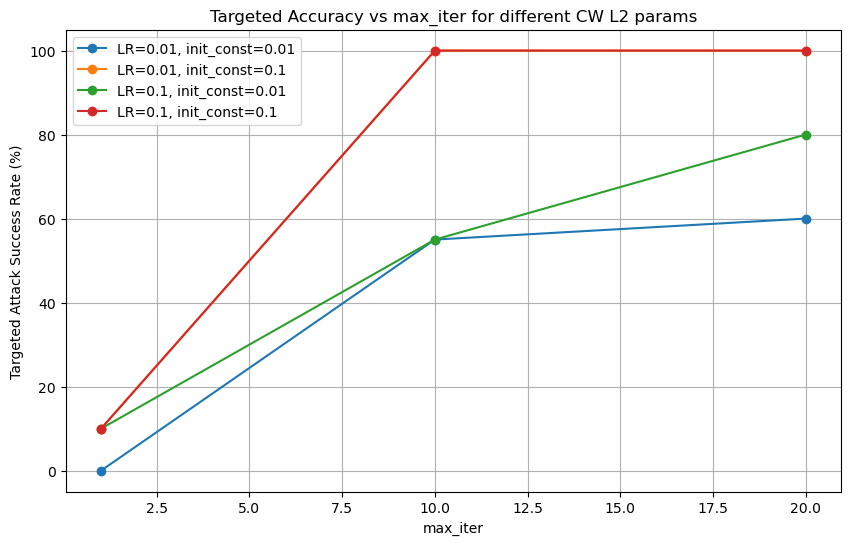

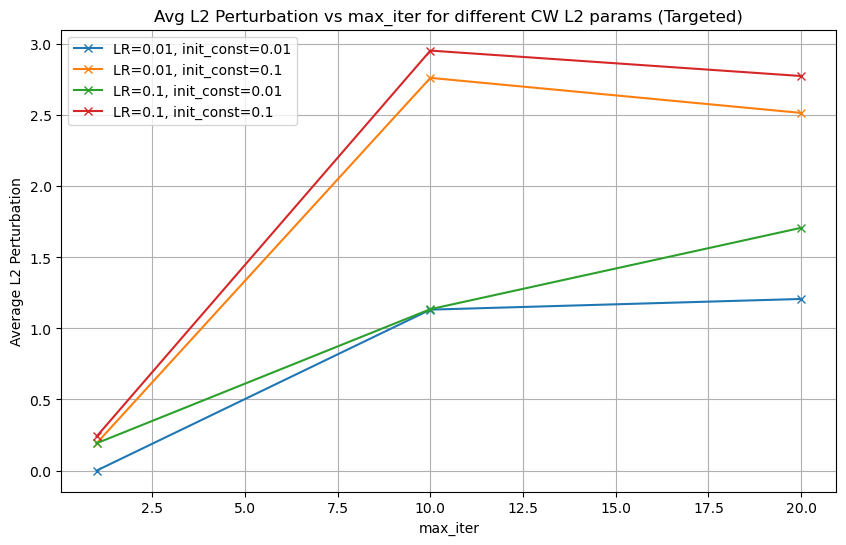

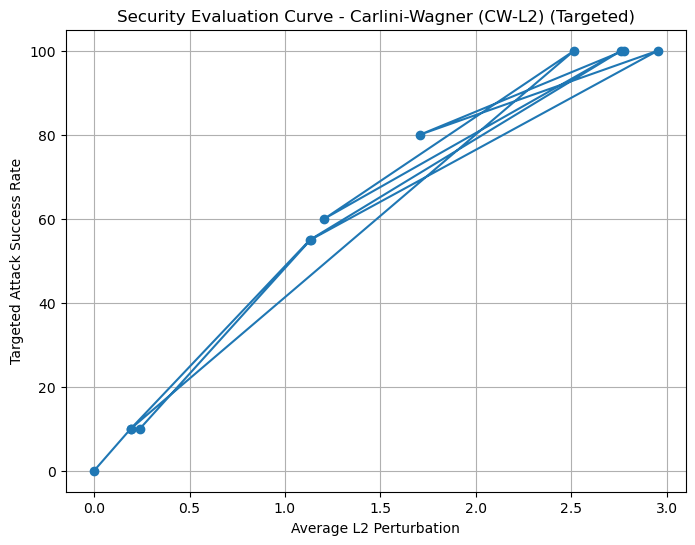

In [12]:
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Targeted Carlini & Wagner L2 Attack
confidence = 0.1
binary_search_steps = 9
learning_rates = [0.01, 0.1]
max_iters = [1, 10, 20]
initial_consts = [0.01, 0.1]
results = []
perturbations = []
accuracies = []

# Load pre-saved test set (images and true labels)
x_test, y_test = torch.load('xy_test.pt')

# Prepare directory for saving adversarial samples
save_dir = '../adv_samples/CW_L2_targeted'
os.makedirs(save_dir, exist_ok=True)

# Randomly select a reproducible subset of 20 samples for evaluation
subset_size = 20
indices = np.random.choice(len(x_test), size=subset_size, replace=False)
np.save(os.path.join(save_dir, 'cw_L2_targeted_indices.npy'), indices)
x_test_subset = x_test[indices]
y_true_label = y_test[indices]

# Define target labels (next class, cyclic)
num_classes = len(LABELS)
target_labels = (y_true_label + 1) % num_classes
y_target_onehot = np.eye(num_classes)[target_labels.numpy()]

for lr in learning_rates:
    for max_iter in max_iters:
        for init_const in initial_consts:
            # Initialize targeted Carlini & Wagner L2 attack
            attack = CarliniL2Method(
                classifier=pytorch_nn1,
                confidence=confidence,
                max_iter=max_iter,
                learning_rate=lr,
                binary_search_steps=binary_search_steps,
                initial_const=init_const,
                targeted=True
            )
            
            # Generate targeted adversarial examples
            x_test_cpu = x_test_subset.numpy()
            x_test_adv_cw = attack.generate(x=x_test_cpu, y=y_target_onehot)
            x_adv_tensor = torch.from_numpy(x_test_adv_cw)

            # Save adversarial samples for this parameter combination
            save_path = os.path.join(
                save_dir,
                f'cw_L2_targeted_lr_{lr}_maxiter_{max_iter}_initconst_{init_const}.npy'
            )
            np.save(save_path, x_test_adv_cw)

            # Batch predictions for efficient GPU inference
            batch_size = 64
            preds_list = []
            with torch.no_grad():
                for i in range(0, x_adv_tensor.size(0), batch_size):
                    batch = x_adv_tensor[i:i+batch_size].to(device)
                    outputs = nn1(batch)
                    preds = torch.argmax(outputs, dim=1)
                    preds_list.append(preds.cpu())
                    
            preds_cpu = torch.cat(preds_list).numpy()
            y_pred_labels = [str(LABELS[idx]).strip() for idx in preds_cpu]
            y_target_labels = [str(LABELS[idx]).strip() for idx in target_labels.numpy()]

            # Compute targeted attack success rate
            correct = sum(
                normalize_string(pred) == normalize_string(true)
                for pred, true in zip(y_pred_labels, y_target_labels)
            )
            accuracy = correct / len(y_target_labels)
            
            # Calcolo della norma L2 della perturbazione per ogni sample (batch-wise)
            diff = x_adv_tensor - x_test_subset  # (batch_size, C, H, W)
            perturbation_l2 = torch.norm(diff.view(diff.size(0), -1), p=2, dim=1)  # shape: (batch_size,)
            avg_l2 = perturbation_l2.mean().item()
            max_l2 = perturbation_l2.max().item()

            print(
                f"LR: {lr}, max_iter: {max_iter}, init_const: {init_const} | "
                f"Avg L2: {avg_l2:.4f}, Max L2: {max_l2:.4f}, "
                f"Targeted Success Rate: {accuracy * 100:.2f}%"
            )

            # Collect parameters and results for plotting
            results.append({
                "learning_rate": lr,
                "max_iter": max_iter,
                "initial_const": init_const,
                "accuracy": accuracy * 100,
                "average_l2": avg_l2,
                "max_l2": max_l2
            })

            # Collect for security evaluation curve (usa L2)
            perturbations.append(avg_l2)
            accuracies.append(accuracy * 100)

# Convert to DataFrame for easy plotting
df = pd.DataFrame(results)

# Accuracy vs max_iter for different CW L2 params Plot (Targeted)
plt.figure(figsize=(10, 6))
for (lr, init_const), group in df.groupby(['learning_rate', 'initial_const']):
    plt.plot(group["max_iter"], group["accuracy"], marker='o', label=f"LR={lr}, init_const={init_const}")
plt.xlabel("max_iter")
plt.ylabel("Targeted Attack Success Rate (%)")
plt.title("Targeted Accuracy vs max_iter for different CW L2 params")
plt.legend()
plt.grid(True)
plt.show()

# Average L2 Perturbation vs max_iter for different CW L2 params Plot (Targeted)
plt.figure(figsize=(10, 6))
for (lr, init_const), group in df.groupby(['learning_rate', 'initial_const']):
    plt.plot(group["max_iter"], group["average_l2"], marker='x', label=f"LR={lr}, init_const={init_const}")
plt.xlabel("max_iter")
plt.ylabel("Average L2 Perturbation")
plt.title("Avg L2 Perturbation vs max_iter for different CW L2 params (Targeted)")
plt.legend()
plt.grid(True)
plt.show()

# Security Evaluation Curve Plot - CW (Targeted, L2)
plt.figure(figsize=(8, 6))
plt.plot(perturbations, accuracies, marker='o', linestyle='-')
plt.xlabel("Average L2 Perturbation")
plt.ylabel("Targeted Attack Success Rate")
plt.title("Security Evaluation Curve - Carlini-Wagner (CW-L2) (Targeted)")
plt.grid(True)
plt.show()

## Load NN2

In [9]:
from torchvision.models import resnet50
import torch.nn.functional as F
import pickle

# Load the pre-trained ResNet50 model
nn2 = resnet50(num_classes=8631)    # ResNet50 model with 8631 classes (as per the dataset)

# Load the weights from the file
with open('./NN2-weight/resnet50_ft_weight.pkl', 'rb') as f:
    state_dict = pickle.load(f)

# Convert all numpy arrays to torch tensors
for k, v in state_dict.items():
    if isinstance(v, np.ndarray):
        state_dict[k] = torch.from_numpy(v)

# Load the state_dict into the model
nn2.load_state_dict(state_dict)

# Evaluate the model on the test set
nn2 = nn2.eval().to(device)

### Accuracy Evaluation of NN2

In [10]:
# Load x_test and y_test (clean images and labels) from xy_test.pt
x_test, y_test = torch.load('xy_test.pt')

# Precomputed variables
label_to_idx = {normalize_string(str(LABELS[i])): i for i in range(len(LABELS))}
identities = pd.read_csv('../dataset/identities.csv')
name_to_id = {normalize_string(row['Name']): row['Class_ID'] for _, row in identities.iterrows()}
test_names = [normalize_string(n) for n in identities['Name']]
test_indices = [label_to_idx[n] for n in test_names if n in label_to_idx]
test_indices_tensor = torch.tensor(test_indices).to(device)
idx_to_classid = {i: c for i, c in enumerate(identities['Class_ID'])}

def preprocess_for_resnet(x):
    # x: (N, 3, 160, 160), range [-1, 1] or [0, 1] -> [0, 255], resize, BGR, mean subtraction
    # Resize to (3, 224, 224)
    x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
    # If input is in [-1, 1], bring to [0, 1]
    if x.min() < 0:
        x_resized = (x_resized + 1.0) / 2.0
    # Scale to [0,255]
    x_resized = x_resized * 255.0
    # Convert RGB to BGR
    x_bgr = x_resized[:, [2, 1, 0], :, :]
    # Subtract mean BGR
    mean_bgr = torch.tensor([91.4953, 103.8827, 131.0912], device=x_bgr.device).view(1, 3, 1, 1)
    x_bgr = x_bgr - mean_bgr
    return x_bgr

# Preprocess all images
x_test_resnet = preprocess_for_resnet(x_test)

# Evaluate NN2 on the test set (in batches)
batch_size = 64
num_samples = x_test_resnet.size(0)
correct = 0
total = 0

with torch.no_grad():
    for i in range(0, num_samples, batch_size):
        images = x_test_resnet[i:i+batch_size].to(device)
        labels = y_test[i:i+batch_size]
        outputs = nn2(images)
        # Mask output to only test indices (if necessary)
        mask = torch.full_like(outputs, float('-inf'))
        mask[:, test_indices_tensor] = outputs[:, test_indices_tensor]
        pred_indices = torch.argmax(mask, dim=1).cpu().numpy()
        pred_names = [str(LABELS[idx]).strip() for idx in pred_indices]
        pred_ids = [name_to_id.get(normalize_string(name), None) for name in pred_names]
        # If y_test are indices, map to class IDs
        true_ids = [idx_to_classid[int(lbl)] for lbl in labels]
        for p, t in zip(pred_ids, true_ids):
            if p == t:
                correct += 1
            total += 1

accuracy = correct / total if total > 0 else 0
print(f"Correct predicted sample: {correct} on a total of {total} samples")
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

Correct predicted sample: 2248 on a total of 2408 samples
Accuracy on test set: 93.36%


 ### Transferability Evaluation of Non-targeted (Error-Generic) Attacks

#### FGSM

Testing adversarial samples with epsilon=0.001
Epsilon: 0.001, Avg perturbation: 0.0009, L∞: 0.0010, Accuracy: 93.36%
Testing adversarial samples with epsilon=0.005
Epsilon: 0.005, Avg perturbation: 0.0047, L∞: 0.0050, Accuracy: 92.65%
Testing adversarial samples with epsilon=0.010
Epsilon: 0.010, Avg perturbation: 0.0094, L∞: 0.0100, Accuracy: 91.03%
Testing adversarial samples with epsilon=0.025
Epsilon: 0.025, Avg perturbation: 0.0235, L∞: 0.0250, Accuracy: 85.47%
Testing adversarial samples with epsilon=0.050
Epsilon: 0.050, Avg perturbation: 0.0467, L∞: 0.0500, Accuracy: 72.26%
Testing adversarial samples with epsilon=0.075
Epsilon: 0.075, Avg perturbation: 0.0697, L∞: 0.0750, Accuracy: 60.38%
Testing adversarial samples with epsilon=0.100
Epsilon: 0.100, Avg perturbation: 0.0924, L∞: 0.1000, Accuracy: 47.67%


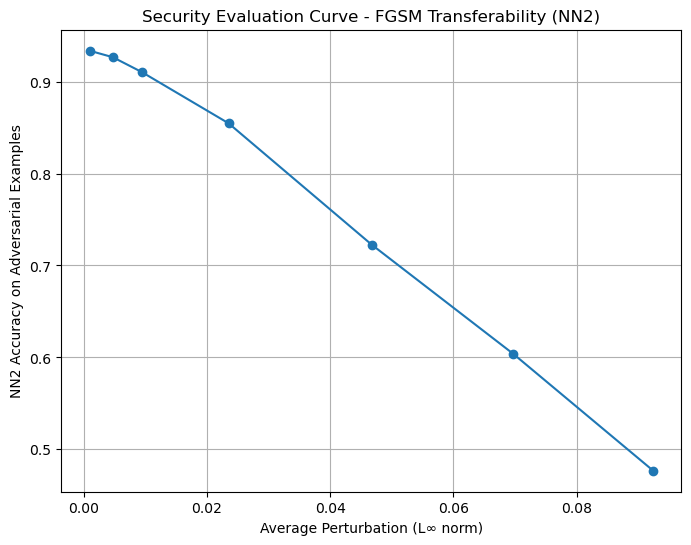

In [10]:
# Load x_test and y_test
x_test, y_test = torch.load('xy_test.pt')

# Build your mappings and label indices
label_to_idx = {normalize_string(str(LABELS[i])): i for i in range(len(LABELS))}
identities = pd.read_csv('../dataset/identities.csv')
name_to_id = {normalize_string(row['Name']): row['Class_ID'] for _, row in identities.iterrows()}
test_names = [normalize_string(n) for n in identities['Name']]
test_indices = [label_to_idx[n] for n in test_names if n in label_to_idx]
test_indices_tensor = torch.tensor(test_indices).to(device)
idx_to_classid = {i: c for i, c in enumerate(identities['Class_ID'])}

# Preprocessing for NN2 (ResNet50 with BGR mean subtraction)
mean_bgr = torch.tensor([91.4953, 103.8827, 131.0912]).view(1, 3, 1, 1)

def preprocess_for_resnet(x):
    # x: (N, 3, 160, 160), value range usually [-1, 1] or [0, 1]
    x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
    # If range is [-1,1], bring to [0,1]
    if x.min() < 0:
        x_resized = (x_resized + 1.0) / 2.0
    x_resized = x_resized * 255.0
    x_bgr = x_resized[:, [2, 1, 0], :, :]  # RGB to BGR
    x_bgr = x_bgr - mean_bgr.to(x_bgr.device)
    return x_bgr

# Epsilon values to test
epsilon_values = [0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1]
accuracies = []
perturbations = []

for epsilon in epsilon_values:
    print(f"Testing adversarial samples with epsilon={epsilon:.3f}")

    # Load adversarial samples generated with NN1 for this epsilon
    adv_path = f'../adv_samples/FGSM/fgsm_eps_{epsilon:.3f}.npy'
    adv_samples = np.load(adv_path)  # shape: (N, 3, 160, 160)
    adv_samples_tensor = torch.from_numpy(adv_samples).float()

    # Compute average and max perturbation
    perturbation = torch.mean(torch.abs(adv_samples_tensor - x_test)).item()
    L_inf_perturbation = torch.max(torch.abs(adv_samples_tensor - x_test)).item()
    perturbations.append(perturbation)
    
    # Preprocess adversarial images in a batch
    adv_samples_preproc = preprocess_for_resnet(adv_samples_tensor)

    # Evaluate NN2 on adversarial samples (batch, GPU)
    batch_size = 64
    num_samples = adv_samples_preproc.size(0)
    correct = 0
    total = 0

    nn2.eval()
    
    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            images = adv_samples_preproc[i:i+batch_size].to(device)
            labels = y_test[i:i+batch_size]
            outputs = nn2(images)
            # Mask output to only test indices
            mask = torch.full_like(outputs, float('-inf'))
            mask[:, test_indices_tensor] = outputs[:, test_indices_tensor]
            pred_indices = torch.argmax(mask, dim=1).cpu().numpy()
            pred_names = [str(LABELS[idx]).strip() for idx in pred_indices]
            pred_ids = [name_to_id.get(normalize_string(name), None) for name in pred_names]
            true_ids = [idx_to_classid[int(lbl)] for lbl in labels]
            for p, t in zip(pred_ids, true_ids):
                if p == t:
                    correct += 1
                total += 1

    accuracy = correct / total if total > 0 else 0
    accuracies.append(accuracy)
    print(f'Epsilon: {epsilon:.3f}, Avg perturbation: {perturbation:.4f}, L∞: {L_inf_perturbation:.4f}, Accuracy: {accuracy*100:.2f}%')

# Security Evaluation Curve
plt.figure(figsize=(8, 6))
plt.plot(perturbations, accuracies, marker='o', linestyle='-')
plt.xlabel("Average Perturbation (L∞ norm)")
plt.ylabel("NN2 Accuracy on Adversarial Examples")
plt.title("Security Evaluation Curve - FGSM Transferability (NN2)")
plt.grid(True)
plt.show()

#### BIM


Evaluating BIM adversarial samples with epsilon = 0.001 and max_iter = 5


100%|██████████| 38/38 [00:03<00:00, 10.91it/s]


Epsilon: 0.001, max_iter: 5, Average perturbation: 0.0009, L∞: 0.0010, Accuracy: 93.36%

Evaluating BIM adversarial samples with epsilon = 0.005 and max_iter = 5


100%|██████████| 38/38 [00:03<00:00, 10.91it/s]


Epsilon: 0.005, max_iter: 5, Average perturbation: 0.0039, L∞: 0.0050, Accuracy: 92.48%

Evaluating BIM adversarial samples with epsilon = 0.01 and max_iter = 5


100%|██████████| 38/38 [00:03<00:00, 10.92it/s]


Epsilon: 0.010, max_iter: 5, Average perturbation: 0.0072, L∞: 0.0100, Accuracy: 90.82%

Evaluating BIM adversarial samples with epsilon = 0.025 and max_iter = 5


100%|██████████| 38/38 [00:03<00:00, 10.91it/s]


Epsilon: 0.025, max_iter: 5, Average perturbation: 0.0149, L∞: 0.0250, Accuracy: 83.68%

Evaluating BIM adversarial samples with epsilon = 0.05 and max_iter = 5


100%|██████████| 38/38 [00:03<00:00, 10.90it/s]


Epsilon: 0.050, max_iter: 5, Average perturbation: 0.0247, L∞: 0.0500, Accuracy: 67.61%

Evaluating BIM adversarial samples with epsilon = 0.075 and max_iter = 5


100%|██████████| 38/38 [00:03<00:00, 10.90it/s]


Epsilon: 0.075, max_iter: 5, Average perturbation: 0.0333, L∞: 0.0750, Accuracy: 53.53%

Evaluating BIM adversarial samples with epsilon = 0.1 and max_iter = 5


100%|██████████| 38/38 [00:03<00:00, 10.89it/s]


Epsilon: 0.100, max_iter: 5, Average perturbation: 0.0414, L∞: 0.1000, Accuracy: 43.65%

Evaluating BIM adversarial samples with epsilon = 0.001 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.89it/s]


Epsilon: 0.001, max_iter: 10, Average perturbation: 0.0009, L∞: 0.0010, Accuracy: 93.31%

Evaluating BIM adversarial samples with epsilon = 0.005 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.89it/s]


Epsilon: 0.005, max_iter: 10, Average perturbation: 0.0043, L∞: 0.0050, Accuracy: 92.28%

Evaluating BIM adversarial samples with epsilon = 0.01 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.89it/s]


Epsilon: 0.010, max_iter: 10, Average perturbation: 0.0080, L∞: 0.0100, Accuracy: 90.49%

Evaluating BIM adversarial samples with epsilon = 0.025 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.90it/s]


Epsilon: 0.025, max_iter: 10, Average perturbation: 0.0174, L∞: 0.0250, Accuracy: 81.94%

Evaluating BIM adversarial samples with epsilon = 0.05 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.89it/s]


Epsilon: 0.050, max_iter: 10, Average perturbation: 0.0293, L∞: 0.0500, Accuracy: 63.70%

Evaluating BIM adversarial samples with epsilon = 0.075 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.89it/s]


Epsilon: 0.075, max_iter: 10, Average perturbation: 0.0392, L∞: 0.0750, Accuracy: 48.96%

Evaluating BIM adversarial samples with epsilon = 0.1 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.87it/s]


Epsilon: 0.100, max_iter: 10, Average perturbation: 0.0487, L∞: 0.1000, Accuracy: 39.41%

Evaluating BIM adversarial samples with epsilon = 0.001 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.87it/s]


Epsilon: 0.001, max_iter: 20, Average perturbation: 0.0009, L∞: 0.0010, Accuracy: 93.27%

Evaluating BIM adversarial samples with epsilon = 0.005 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.87it/s]


Epsilon: 0.005, max_iter: 20, Average perturbation: 0.0045, L∞: 0.0050, Accuracy: 92.23%

Evaluating BIM adversarial samples with epsilon = 0.01 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.87it/s]


Epsilon: 0.010, max_iter: 20, Average perturbation: 0.0086, L∞: 0.0100, Accuracy: 90.41%

Evaluating BIM adversarial samples with epsilon = 0.025 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.86it/s]


Epsilon: 0.025, max_iter: 20, Average perturbation: 0.0195, L∞: 0.0250, Accuracy: 81.85%

Evaluating BIM adversarial samples with epsilon = 0.05 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.86it/s]


Epsilon: 0.050, max_iter: 20, Average perturbation: 0.0333, L∞: 0.0500, Accuracy: 63.37%

Evaluating BIM adversarial samples with epsilon = 0.075 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.86it/s]


Epsilon: 0.075, max_iter: 20, Average perturbation: 0.0451, L∞: 0.0750, Accuracy: 49.96%

Evaluating BIM adversarial samples with epsilon = 0.1 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.86it/s]


Epsilon: 0.100, max_iter: 20, Average perturbation: 0.0564, L∞: 0.1000, Accuracy: 39.24%


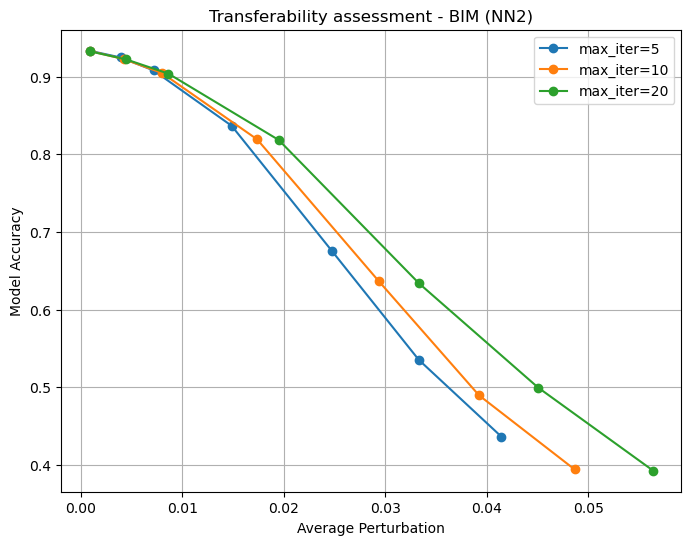

In [22]:
# Load clean test set and true labels
x_test, y_test = torch.load('xy_test.pt')  # x_test: (N, 3, 160, 160), y_test: (N,)

# Preprocessing for NN2 (ResNet50 with BGR mean subtraction)
mean_bgr = torch.tensor([91.4953, 103.8827, 131.0912]).view(1, 3, 1, 1)

def preprocess_for_nn2_batch(x):
    # x: (N, 3, 160, 160), torch tensor in [-1,1] or [0,1]
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    if x.min() < 0:
        x = (x + 1.0) / 2.0
    x = x * 255.0
    x = x[:, [2, 1, 0], :, :]  # RGB → BGR
    x = x - mean_bgr.to(x.device)
    return x

adv_dir = '../adv_samples/BIM'

def get_iter(filename):
    match = re.search(r'iter_([0-9]+)\.npy', filename)
    return int(match.group(1)) if match else float('inf')

files = sorted([f for f in os.listdir(adv_dir) if f.endswith('.npy')], key=get_iter)

results = {}

# Mapping for label comparison
label_to_idx = {normalize_string(str(LABELS[i])): i for i in range(len(LABELS))}
identities = pd.read_csv('../dataset/identities.csv')
name_to_id = {normalize_string(row['Name']): row['Class_ID'] for _, row in identities.iterrows()}
test_names = [normalize_string(n) for n in identities['Name']]
test_indices = [label_to_idx[n] for n in test_names if n in label_to_idx]
test_indices_tensor = torch.tensor(test_indices).to(device)
idx_to_classid = {i: c for i, c in enumerate(identities['Class_ID'])}

# Convert true test set labels to class IDs
y_test_labels = [idx_to_classid[int(lbl)] for lbl in y_test.numpy()]

for file in files:
    match = re.search(r'eps_([0-9.]+)_iter_([0-9]+)\.npy', file)
    if match:
        epsilon = float(match.group(1))
        max_iter = int(match.group(2))
    else:
        print(f"Filename {file} does not match expected pattern.")
        continue

    print(f"\nEvaluating BIM adversarial samples with epsilon = {epsilon} and max_iter = {max_iter}")

    # Load adversarial examples as tensor in the original domain ([0,1] or [-1,1])
    x_adv = np.load(os.path.join(adv_dir, file))
    x_adv_tensor_raw = torch.from_numpy(x_adv).float()   # original shape (N,3,160,160)
    
    # Compute perturbations in the original image space
    diff = torch.abs(x_adv_tensor_raw - x_test)
    avg_perturb = diff.mean().item()
    max_perturb = diff.max().item()

    # Preprocess adversarial images for NN2
    x_adv_tensor = preprocess_for_nn2_batch(x_adv_tensor_raw)
    x_adv_tensor = F.interpolate(x_adv_tensor, size=(224, 224), mode='bilinear', align_corners=False)

    # Batch processing for predictions (GPU)
    batch_size = 64
    correct = 0
    total = 0

    for i in tqdm(range(0, x_adv_tensor.size(0), batch_size)):
        batch_adv = x_adv_tensor[i:i+batch_size].to(device)

        with torch.no_grad():
            outputs = nn2(batch_adv)
            mask = torch.full_like(outputs, float('-inf'))
            mask[:, test_indices_tensor] = outputs[:, test_indices_tensor]
            preds = torch.argmax(mask, dim=1).cpu().numpy()

        pred_names = [str(LABELS[idx]).strip() for idx in preds]
        pred_ids = [name_to_id.get(normalize_string(name), None) for name in pred_names]
        true_ids = y_test_labels[i:i+batch_size]

        for p, t in zip(pred_ids, true_ids):
            if p == t:
                correct += 1
            total += 1

    acc = correct / total

    print(
        f"Epsilon: {epsilon:.3f}, max_iter: {max_iter}, "
        f"Average perturbation: {avg_perturb:.4f}, "
        f"L∞: {max_perturb:.4f}, Accuracy: {acc * 100:.2f}%"
    )

    if max_iter not in results:
        results[max_iter] = {"perturbations": [], "accuracies": [], "epsilons": []}
    results[max_iter]["perturbations"].append(avg_perturb)
    results[max_iter]["accuracies"].append(acc)
    results[max_iter]["epsilons"].append(epsilon)

# Plot with different colors for each iteration
plt.figure(figsize=(8, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green']
for idx, (max_iter, vals) in enumerate(sorted(results.items())):
    plt.plot(
        vals["perturbations"], vals["accuracies"],
        marker='o', linestyle='-', color=colors[idx % len(colors)],
        label=f"max_iter={max_iter}"
    )
plt.xlabel("Average Perturbation")
plt.ylabel("Model Accuracy")
plt.title("Transferability assessment - BIM (NN2)")
plt.legend()
plt.grid(True)
plt.show()

#### PGD


Evaluating PGD adversarial samples with epsilon = 0.001, max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.83it/s]


Epsilon: 0.001, max_iter: 10, Average perturbation: 0.0009, L∞: 0.0010, Accuracy: 93.31%

Evaluating PGD adversarial samples with epsilon = 0.005, max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.86it/s]


Epsilon: 0.005, max_iter: 10, Average perturbation: 0.0043, L∞: 0.0050, Accuracy: 92.36%

Evaluating PGD adversarial samples with epsilon = 0.01, max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.86it/s]


Epsilon: 0.010, max_iter: 10, Average perturbation: 0.0082, L∞: 0.0100, Accuracy: 90.61%

Evaluating PGD adversarial samples with epsilon = 0.025, max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.86it/s]


Epsilon: 0.025, max_iter: 10, Average perturbation: 0.0181, L∞: 0.0250, Accuracy: 82.39%

Evaluating PGD adversarial samples with epsilon = 0.05, max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.86it/s]


Epsilon: 0.050, max_iter: 10, Average perturbation: 0.0320, L∞: 0.0500, Accuracy: 66.07%

Evaluating PGD adversarial samples with epsilon = 0.075, max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.85it/s]


Epsilon: 0.075, max_iter: 10, Average perturbation: 0.0447, L∞: 0.0750, Accuracy: 53.11%

Evaluating PGD adversarial samples with epsilon = 0.1, max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.85it/s]


Epsilon: 0.100, max_iter: 10, Average perturbation: 0.0571, L∞: 0.1000, Accuracy: 43.94%

Evaluating PGD adversarial samples with epsilon = 0.001, max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.86it/s]


Epsilon: 0.001, max_iter: 20, Average perturbation: 0.0010, L∞: 0.0010, Accuracy: 93.31%

Evaluating PGD adversarial samples with epsilon = 0.005, max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.84it/s]


Epsilon: 0.005, max_iter: 20, Average perturbation: 0.0046, L∞: 0.0050, Accuracy: 92.19%

Evaluating PGD adversarial samples with epsilon = 0.01, max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.85it/s]


Epsilon: 0.010, max_iter: 20, Average perturbation: 0.0089, L∞: 0.0100, Accuracy: 90.45%

Evaluating PGD adversarial samples with epsilon = 0.025, max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.85it/s]


Epsilon: 0.025, max_iter: 20, Average perturbation: 0.0201, L∞: 0.0250, Accuracy: 82.31%

Evaluating PGD adversarial samples with epsilon = 0.05, max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.86it/s]


Epsilon: 0.050, max_iter: 20, Average perturbation: 0.0349, L∞: 0.0500, Accuracy: 64.78%

Evaluating PGD adversarial samples with epsilon = 0.075, max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.85it/s]


Epsilon: 0.075, max_iter: 20, Average perturbation: 0.0479, L∞: 0.0750, Accuracy: 51.58%

Evaluating PGD adversarial samples with epsilon = 0.1, max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.85it/s]


Epsilon: 0.100, max_iter: 20, Average perturbation: 0.0606, L∞: 0.1000, Accuracy: 41.49%


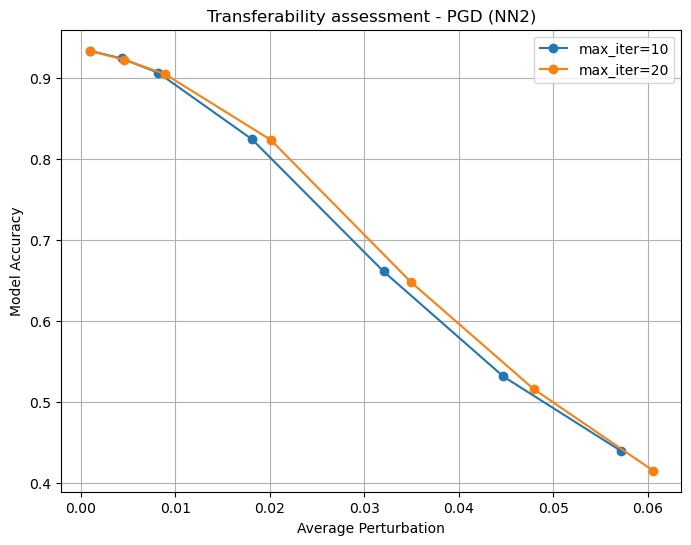

In [23]:
# Load clean test set and labels
x_test, y_test = torch.load('xy_test.pt')  # x_test: (N, 3, 160, 160), y_test: (N,)

# Preprocessing for NN2 (ResNet50 with BGR mean subtraction)
mean_bgr = torch.tensor([91.4953, 103.8827, 131.0912]).view(1, 3, 1, 1)

def preprocess_for_nn2_batch(x):
    # x: (N, 3, 160, 160), torch tensor in [-1,1] or [0,1]
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    if x.min() < 0:
        x = (x + 1.0) / 2.0
    x = x * 255.0
    x = x[:, [2, 1, 0], :, :]  # RGB → BGR
    x = x - mean_bgr.to(x.device)
    return x

adv_dir = "../adv_samples/PGD"

def parse_filename(file):
    match = re.search(r'eps_([0-9.]+)_iter_([0-9]+)\.npy', file)
    if match:
        return float(match.group(1)), int(match.group(2))
    return None, None

files = sorted([f for f in os.listdir(adv_dir) if f.endswith(".npy")], key=lambda f: parse_filename(f)[1])

results = {}

# Mapping for label comparison
label_to_idx = {normalize_string(str(LABELS[i])): i for i in range(len(LABELS))}
identities = pd.read_csv('../dataset/identities.csv')
name_to_id = {normalize_string(row['Name']): row['Class_ID'] for _, row in identities.iterrows()}
test_names = [normalize_string(n) for n in identities['Name']]
test_indices = [label_to_idx[n] for n in test_names if n in label_to_idx]
test_indices_tensor = torch.tensor(test_indices).to(device)
idx_to_classid = {i: c for i, c in enumerate(identities['Class_ID'])}

# True class IDs for x_test, matching adversarial samples
y_test_labels = [idx_to_classid[int(lbl)] for lbl in y_test.numpy()]

for file in files:
    epsilon, max_iter = parse_filename(file)
    if epsilon is None or max_iter is None:
        print(f"Filename {file} does not match expected pattern.")
        continue

    print(f"\nEvaluating PGD adversarial samples with epsilon = {epsilon}, max_iter = {max_iter}")

    # Load adversarial examples as tensor in the original domain ([0,1] or [-1,1])
    x_adv = np.load(os.path.join(adv_dir, file))
    x_adv_tensor_raw = torch.from_numpy(x_adv).float()   # original shape (N,3,160,160)
    
    # Compute perturbations in the original image space
    diff = torch.abs(x_adv_tensor_raw - x_test)
    avg_perturb = diff.mean().item()
    max_perturb = diff.max().item()

    # Preprocess adversarial images for NN2
    x_adv_tensor = preprocess_for_nn2_batch(x_adv_tensor_raw)
    x_adv_tensor = F.interpolate(x_adv_tensor, size=(224, 224), mode='bilinear', align_corners=False)

    # Batch processing for predictions (to use GPU-acceleration)
    batch_size = 64
    correct = 0
    total = 0

    for i in tqdm(range(0, x_adv_tensor.size(0), batch_size)):
        batch_adv = x_adv_tensor[i:i+batch_size].to(device)

        with torch.no_grad():
            outputs = nn2(batch_adv)
            mask = torch.full_like(outputs, float('-inf'))
            mask[:, test_indices_tensor] = outputs[:, test_indices_tensor]
            preds = torch.argmax(mask, dim=1).cpu().numpy()

        pred_names = [str(LABELS[idx]).strip() for idx in preds]
        pred_ids = [name_to_id.get(normalize_string(name), None) for name in pred_names]
        true_ids = y_test_labels[i:i+batch_size]

        for p, t in zip(pred_ids, true_ids):
            if p is not None and t is not None and p == t:
                correct += 1
            total += 1

    acc = correct / total if total > 0 else 0

    print(
        f"Epsilon: {epsilon:.3f}, max_iter: {max_iter}, "
        f"Average perturbation: {avg_perturb:.4f}, "
        f"L∞: {max_perturb:.4f}, Accuracy: {acc * 100:.2f}%"
    )

    if max_iter not in results:
        results[max_iter] = {"perturbations": [], "accuracies": [], "epsilons": []}
    results[max_iter]["perturbations"].append(avg_perturb)
    results[max_iter]["accuracies"].append(acc)
    results[max_iter]["epsilons"].append(epsilon)

# Security Evaluation Curve Plot - PGD
plt.figure(figsize=(8, 6))
colors = ['tab:blue', 'tab:orange']
for idx, (max_iter, vals) in enumerate(sorted(results.items())):
    plt.plot(
        vals["perturbations"], vals["accuracies"],
        marker='o', linestyle='-', color=colors[idx % len(colors)],
        label=f"max_iter={max_iter}"
    )
plt.xlabel("Average Perturbation")
plt.ylabel("Model Accuracy")
plt.title("Transferability assessment - PGD (NN2)")
plt.legend()
plt.grid(True)
plt.show()

#### DeepFool


Evaluating DeepFool adversarial samples with epsilon = 0.02


100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


Epsilon: 0.020, Average perturbation: 0.0000, L∞: 0.0135, Accuracy: 96.00%


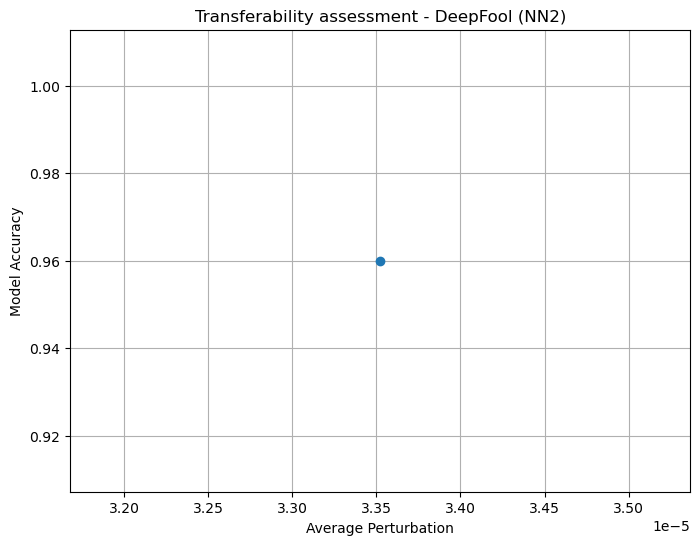

In [24]:
# Load clean test set and labels
x_test, y_test = torch.load('xy_test.pt')  # x_test: (N, 3, 160, 160), y_test: (N,)

# Load indices
deepfool_indices = np.load('../adv_samples/DeepFool/deepfool_indices.npy')

# Preprocessing for NN2 (ResNet50 with BGR mean subtraction)
mean_bgr = torch.tensor([91.4953, 103.8827, 131.0912]).view(1, 3, 1, 1)

def preprocess_for_nn2_batch(x):
    # x: (N, 3, 160, 160), can be torch tensor or numpy
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    if x.min() < 0:
        x = (x + 1.0) / 2.0
    x = x * 255.0
    x = x[:, [2, 1, 0], :, :]  # RGB → BGR
    x = x - mean_bgr.to(x.device)
    return x

adv_dir = '../adv_samples/DeepFool'
files = sorted([f for f in os.listdir(adv_dir) if f.endswith('.npy') and 'eps' in f])

# Label mapping as in other attacks
label_to_idx = {normalize_string(str(LABELS[i])): i for i in range(len(LABELS))}
identities = pd.read_csv('../dataset/identities.csv')
name_to_id = {normalize_string(row['Name']): row['Class_ID'] for _, row in identities.iterrows()}
test_names = [normalize_string(n) for n in identities['Name']]
test_indices = [label_to_idx[n] for n in test_names if n in label_to_idx]
test_indices_tensor = torch.tensor(test_indices).to(device)
idx_to_classid = {i: c for i, c in enumerate(identities['Class_ID'])}
y_test_labels = [idx_to_classid[int(lbl)] for lbl in y_test.numpy()]

# True class IDs for the selected subset
y_test_subset = y_test[deepfool_indices]
y_test_labels = [idx_to_classid[int(lbl)] for lbl in y_test_subset.numpy()]

epsilons, accuracies, perturbations, linf_perturbations = [], [], [], []

for file in files:
    match = re.search(r'eps_([0-9.]+)\.npy', file)
    if not match:
        continue
    epsilon = float(match.group(1))
    epsilons.append(epsilon)
    print(f"\nEvaluating DeepFool adversarial samples with epsilon = {epsilon}")

    # Load adversarial examples as tensor in the original domain
    x_adv = np.load(os.path.join(adv_dir, file))
    x_adv_tensor_raw = torch.from_numpy(x_adv).float()

    # Perturbation calculated on the subset of 10 samples
    x_test_subset = x_test[deepfool_indices]
    diff = torch.abs(x_adv_tensor_raw - x_test_subset)
    avg_perturb = diff.mean().item()
    max_perturb = diff.max().item()

    # Preprocess adversarial images for NN2
    x_adv_tensor = preprocess_for_nn2_batch(x_adv_tensor_raw)
    x_adv_tensor = F.interpolate(x_adv_tensor, size=(224, 224), mode='bilinear', align_corners=False)

    # Batch processing for predictions (GPU)
    batch_size = 64
    correct = 0
    total = 0

    for i in tqdm(range(0, x_adv_tensor.size(0), batch_size)):
        batch_adv = x_adv_tensor[i:i+batch_size].to(device)
        with torch.no_grad():
            outputs = nn2(batch_adv)
            mask = torch.full_like(outputs, float('-inf'))
            mask[:, test_indices_tensor] = outputs[:, test_indices_tensor]
            preds = torch.argmax(mask, dim=1).cpu().numpy()
        pred_names = [str(LABELS[idx]).strip() for idx in preds]
        pred_ids = [name_to_id.get(normalize_string(name), None) for name in pred_names]
        true_ids = y_test_labels[i:i+batch_size]
        for p, t in zip(pred_ids, true_ids):
            if p is not None and t is not None and p == t:
                correct += 1
            total += 1

    acc = correct / total if total > 0 else 0

    print(
        f"Epsilon: {epsilon:.3f}, "
        f"Average perturbation: {avg_perturb:.4f}, "
        f"L∞: {max_perturb:.4f}, Accuracy: {acc * 100:.2f}%"
    )
    
    perturbations.append(avg_perturb)
    accuracies.append(acc)
    linf_perturbations.append(max_perturb)

# Security Evaluation Curve Plot - DeepFool
plt.figure(figsize=(8, 6))
plt.plot(perturbations, accuracies, marker='o', linestyle='-')
plt.xlabel("Average Perturbation")
plt.ylabel("Model Accuracy")
plt.title("Transferability assessment - DeepFool (NN2)")
plt.grid(True)
plt.show()

#### Carlini-Wagner (CW) L_Inf method

Filename cw_indices.npy does not match expected pattern.

Evaluating CW adversarial samples: lr=0.01, max_iter=10, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


lr: 0.01, max_iter: 10, init_const: 0.01, Average perturbation: 0.0079, L∞: 0.0200, Accuracy: 95.00%

Evaluating CW adversarial samples: lr=0.01, max_iter=10, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 31.38it/s]


lr: 0.01, max_iter: 10, init_const: 0.1, Average perturbation: 0.0079, L∞: 0.0200, Accuracy: 95.00%

Evaluating CW adversarial samples: lr=0.01, max_iter=1, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 31.38it/s]


lr: 0.01, max_iter: 1, init_const: 0.01, Average perturbation: 0.0046, L∞: 0.0100, Accuracy: 95.00%

Evaluating CW adversarial samples: lr=0.01, max_iter=1, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 32.93it/s]


lr: 0.01, max_iter: 1, init_const: 0.1, Average perturbation: 0.0046, L∞: 0.0100, Accuracy: 95.00%

Evaluating CW adversarial samples: lr=0.01, max_iter=20, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 33.01it/s]


lr: 0.01, max_iter: 20, init_const: 0.01, Average perturbation: 0.0079, L∞: 0.0200, Accuracy: 95.00%

Evaluating CW adversarial samples: lr=0.01, max_iter=20, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 33.22it/s]


lr: 0.01, max_iter: 20, init_const: 0.1, Average perturbation: 0.0079, L∞: 0.0200, Accuracy: 95.00%

Evaluating CW adversarial samples: lr=0.1, max_iter=10, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 33.19it/s]


lr: 0.1, max_iter: 10, init_const: 0.01, Average perturbation: 0.0655, L∞: 0.0999, Accuracy: 80.00%

Evaluating CW adversarial samples: lr=0.1, max_iter=10, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 33.45it/s]


lr: 0.1, max_iter: 10, init_const: 0.1, Average perturbation: 0.0655, L∞: 0.0999, Accuracy: 80.00%

Evaluating CW adversarial samples: lr=0.1, max_iter=1, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 33.85it/s]


lr: 0.1, max_iter: 1, init_const: 0.01, Average perturbation: 0.0655, L∞: 0.0999, Accuracy: 80.00%

Evaluating CW adversarial samples: lr=0.1, max_iter=1, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 33.56it/s]


lr: 0.1, max_iter: 1, init_const: 0.1, Average perturbation: 0.0655, L∞: 0.0999, Accuracy: 80.00%

Evaluating CW adversarial samples: lr=0.1, max_iter=20, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 32.77it/s]


lr: 0.1, max_iter: 20, init_const: 0.01, Average perturbation: 0.0655, L∞: 0.0999, Accuracy: 80.00%

Evaluating CW adversarial samples: lr=0.1, max_iter=20, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 33.88it/s]


lr: 0.1, max_iter: 20, init_const: 0.1, Average perturbation: 0.0655, L∞: 0.0999, Accuracy: 80.00%


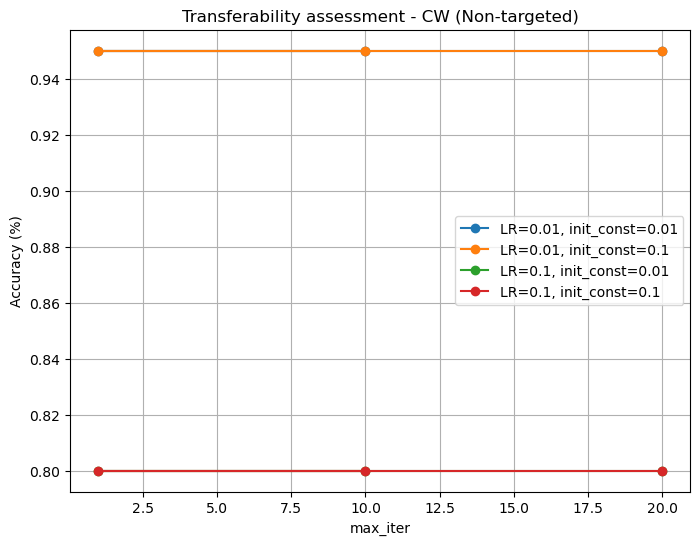

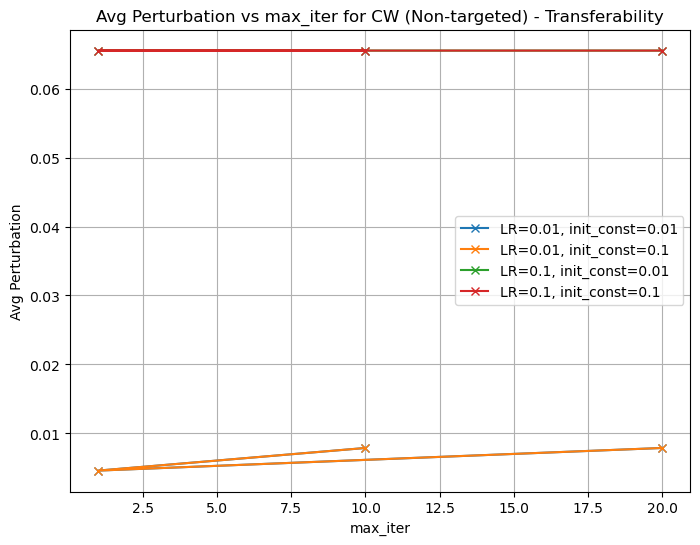

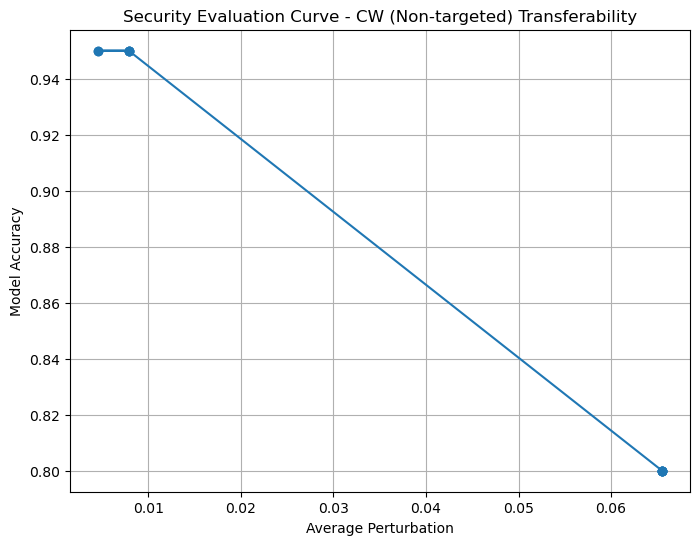

In [15]:
# Load clean test set and labels
x_test, y_test = torch.load('xy_test.pt')  # x_test: (N, 3, 160, 160), y_test: (N,)

# Load indices
cw_indices = np.load('../adv_samples/CW/cw_indices.npy')

# Preprocessing for NN2 (ResNet50 with BGR mean subtraction)
mean_bgr = torch.tensor([91.4953, 103.8827, 131.0912]).view(1, 3, 1, 1)
def preprocess_for_nn2_batch(x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    if x.min() < 0:
        x = (x + 1.0) / 2.0
    x = x * 255.0
    x = x[:, [2, 1, 0], :, :]
    x = x - mean_bgr.to(x.device)
    return x

adv_dir = '../adv_samples/CW'
files = sorted([f for f in os.listdir(adv_dir) if f.endswith('.npy')])

# Label mapping
label_to_idx = {normalize_string(str(LABELS[i])): i for i in range(len(LABELS))}
identities = pd.read_csv('../dataset/identities.csv')
name_to_id = {normalize_string(row['Name']): row['Class_ID'] for _, row in identities.iterrows()}
test_names = [normalize_string(n) for n in identities['Name']]
test_indices = [label_to_idx[n] for n in test_names if n in label_to_idx]
test_indices_tensor = torch.tensor(test_indices).to(device)
idx_to_classid = {i: c for i, c in enumerate(identities['Class_ID'])}
y_test_labels = [idx_to_classid[int(lbl)] for lbl in y_test.numpy()]

# True class IDs for the selected subset
y_test_subset = y_test[cw_indices]
y_test_labels = [idx_to_classid[int(lbl)] for lbl in y_test_subset.numpy()]

results = []

for file in files:
    match = re.search(r'lr_([0-9.]+)_maxiter_([0-9]+)_initconst_([0-9.]+)\.npy', file)
    if not match:
        print(f"Filename {file} does not match expected pattern.")
        continue
    lr = float(match.group(1))
    max_iter = int(match.group(2))
    init_const = float(match.group(3))

    print(f"\nEvaluating CW adversarial samples: lr={lr}, max_iter={max_iter}, init_const={init_const}")

    # Load adversarial examples as tensor in the original domain
    x_adv = np.load(os.path.join(adv_dir, file))
    x_adv_tensor_raw = torch.from_numpy(x_adv).float()   # (N, 3, 160, 160)

    # Compute perturbations
    x_test_subset = x_test[cw_indices]
    diff = torch.abs(x_adv_tensor_raw - x_test_subset)
    avg_perturb = diff.mean().item()
    max_perturb = diff.max().item()

    # Preprocess adversarial images for NN2
    x_adv_tensor = preprocess_for_nn2_batch(x_adv_tensor_raw)
    x_adv_tensor = F.interpolate(x_adv_tensor, size=(224, 224), mode='bilinear', align_corners=False)
    
    # Batch prediction (GPU)
    batch_size = 64
    correct = 0
    total = 0

    for i in tqdm(range(0, x_adv_tensor.size(0), batch_size)):
        batch_adv = x_adv_tensor[i:i+batch_size].to(device)
        
        with torch.no_grad():
            outputs = nn2(batch_adv)
            mask = torch.full_like(outputs, float('-inf'))
            mask[:, test_indices_tensor] = outputs[:, test_indices_tensor]
            preds = torch.argmax(mask, dim=1).cpu().numpy()
        
        pred_names = [str(LABELS[idx]).strip() for idx in preds]
        pred_ids = [name_to_id.get(normalize_string(name), None) for name in pred_names]
        true_ids = y_test_labels[i:i+batch_adv.size(0)]
        
        for p, t in zip(pred_ids, true_ids):
            if p is not None and t is not None and p == t:
                correct += 1
            total += 1

    acc = correct / total if total > 0 else 0

    print(
        f"lr: {lr}, max_iter: {max_iter}, init_const: {init_const}, "
        f"Average perturbation: {avg_perturb:.4f}, "
        f"L∞: {max_perturb:.4f}, Accuracy: {acc * 100:.2f}%"
    )

    results.append({
        "learning_rate": lr,
        "max_iter": max_iter,
        "initial_const": init_const,
        "accuracy": acc,
        "average_perturbation": avg_perturb,
        "max_perturbation": max_perturb
    })

# Plot Security Evaluation Curve
df = pd.DataFrame(results)
plt.figure(figsize=(8, 6))
for (lr, init_const), group in df.groupby(['learning_rate', 'initial_const']):
    plt.plot(group["max_iter"], group["accuracy"], marker='o', label=f"LR={lr}, init_const={init_const}")
plt.xlabel("max_iter")
plt.ylabel("Accuracy (%)")
plt.title("Transferability assessment - CW (Non-targeted)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
for (lr, init_const), group in df.groupby(['learning_rate', 'initial_const']):
    plt.plot(group["max_iter"], group["average_perturbation"], marker='x', label=f"LR={lr}, init_const={init_const}")
plt.xlabel("max_iter")
plt.ylabel("Avg Perturbation")
plt.title("Avg Perturbation vs max_iter for CW (Non-targeted) - Transferability")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df["average_perturbation"], df["accuracy"], marker='o', linestyle='-')
plt.xlabel("Average Perturbation")
plt.ylabel("Model Accuracy")
plt.title("Security Evaluation Curve - CW (Non-targeted) Transferability")
plt.grid(True)
plt.show()

#### Carlini-Wagner (CW) L2 Method

Filename cw_L2_indices.npy does not match expected pattern.

Evaluating CW-L2 adversarial samples: lr=0.01, max_iter=10, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 19.58it/s]


lr: 0.01, max_iter: 10, init_const: 0.01, Average L2 perturbation: 0.5974, Max L2: 1.2304, Accuracy: 95.00%

Evaluating CW-L2 adversarial samples: lr=0.01, max_iter=10, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 34.13it/s]


lr: 0.01, max_iter: 10, init_const: 0.1, Average L2 perturbation: 0.6083, Max L2: 1.2958, Accuracy: 95.00%

Evaluating CW-L2 adversarial samples: lr=0.01, max_iter=1, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 33.44it/s]


lr: 0.01, max_iter: 1, init_const: 0.01, Average L2 perturbation: 0.5163, Max L2: 1.7780, Accuracy: 95.00%

Evaluating CW-L2 adversarial samples: lr=0.01, max_iter=1, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 33.55it/s]

lr: 0.01, max_iter: 1, init_const: 0.1, Average L2 perturbation: 0.9041, Max L2: 2.2214, Accuracy: 95.00%

Evaluating CW-L2 adversarial samples: lr=0.01, max_iter=20, init_const=0.01



100%|██████████| 1/1 [00:00<00:00, 33.70it/s]


lr: 0.01, max_iter: 20, init_const: 0.01, Average L2 perturbation: 0.5898, Max L2: 1.2318, Accuracy: 95.00%

Evaluating CW-L2 adversarial samples: lr=0.01, max_iter=20, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 33.97it/s]


lr: 0.01, max_iter: 20, init_const: 0.1, Average L2 perturbation: 0.6038, Max L2: 1.2956, Accuracy: 95.00%

Evaluating CW-L2 adversarial samples: lr=0.1, max_iter=10, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 33.65it/s]


lr: 0.1, max_iter: 10, init_const: 0.01, Average L2 perturbation: 0.6015, Max L2: 1.2428, Accuracy: 95.00%

Evaluating CW-L2 adversarial samples: lr=0.1, max_iter=10, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 33.43it/s]


lr: 0.1, max_iter: 10, init_const: 0.1, Average L2 perturbation: 0.6216, Max L2: 1.4073, Accuracy: 95.00%

Evaluating CW-L2 adversarial samples: lr=0.1, max_iter=1, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 33.57it/s]


lr: 0.1, max_iter: 1, init_const: 0.01, Average L2 perturbation: 0.6941, Max L2: 2.2214, Accuracy: 95.00%

Evaluating CW-L2 adversarial samples: lr=0.1, max_iter=1, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 33.70it/s]


lr: 0.1, max_iter: 1, init_const: 0.1, Average L2 perturbation: 1.0383, Max L2: 2.7747, Accuracy: 95.00%

Evaluating CW-L2 adversarial samples: lr=0.1, max_iter=20, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 33.77it/s]


lr: 0.1, max_iter: 20, init_const: 0.01, Average L2 perturbation: 0.5959, Max L2: 1.2393, Accuracy: 95.00%

Evaluating CW-L2 adversarial samples: lr=0.1, max_iter=20, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 33.88it/s]


lr: 0.1, max_iter: 20, init_const: 0.1, Average L2 perturbation: 0.6221, Max L2: 1.4063, Accuracy: 95.00%


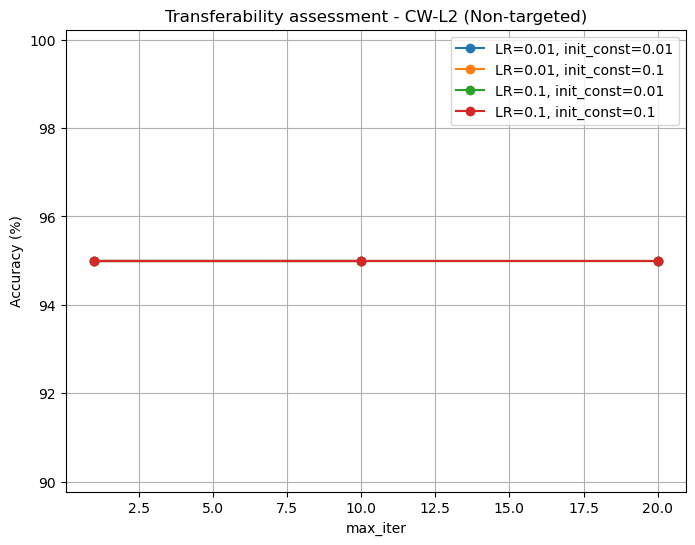

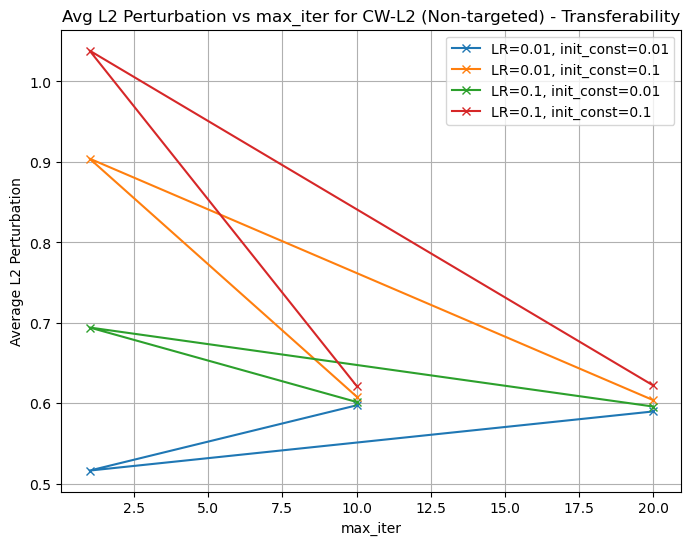

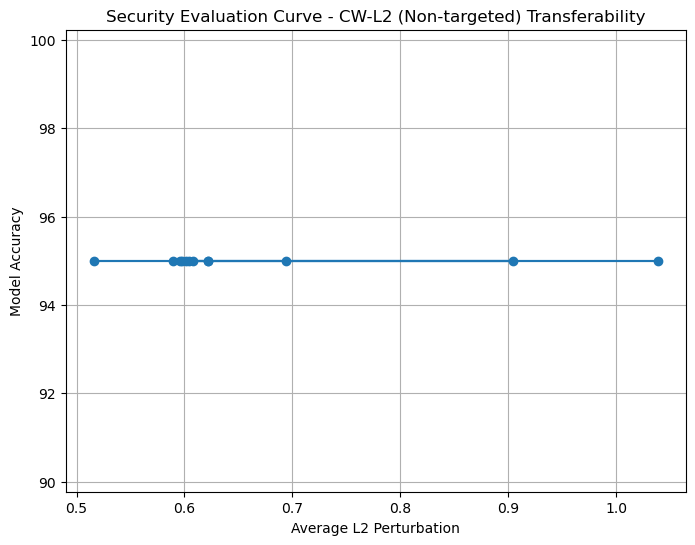

In [11]:
# Load clean test set and labels
x_test, y_test = torch.load('xy_test.pt')  # x_test: (N, 3, 160, 160), y_test: (N,)

# Load indices
cw_L2_indices = np.load('../adv_samples/CW-L2/cw_L2_indices.npy')

# Preprocessing for NN2 (ResNet50 with BGR mean subtraction)
mean_bgr = torch.tensor([91.4953, 103.8827, 131.0912]).view(1, 3, 1, 1)
def preprocess_for_nn2_batch(x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    if x.min() < 0:
        x = (x + 1.0) / 2.0
    x = x * 255.0
    x = x[:, [2, 1, 0], :, :]
    x = x - mean_bgr.to(x.device)
    return x

adv_dir = '../adv_samples/CW-L2'
files = sorted([f for f in os.listdir(adv_dir) if f.endswith('.npy')])

# Label mapping
label_to_idx = {normalize_string(str(LABELS[i])): i for i in range(len(LABELS))}
identities = pd.read_csv('../dataset/identities.csv')
name_to_id = {normalize_string(row['Name']): row['Class_ID'] for _, row in identities.iterrows()}
test_names = [normalize_string(n) for n in identities['Name']]
test_indices = [label_to_idx[n] for n in test_names if n in label_to_idx]
test_indices_tensor = torch.tensor(test_indices).to(device)
idx_to_classid = {i: c for i, c in enumerate(identities['Class_ID'])}
y_test_labels = [idx_to_classid[int(lbl)] for lbl in y_test.numpy()]

# True class IDs for the selected subset
y_test_subset = y_test[cw_L2_indices]
y_test_labels = [idx_to_classid[int(lbl)] for lbl in y_test_subset.numpy()]

results = []

for file in files:
    match = re.search(r'lr_([0-9.]+)_maxiter_([0-9]+)_initconst_([0-9.]+)\.npy', file)
    if not match:
        print(f"Filename {file} does not match expected pattern.")
        continue
    lr = float(match.group(1))
    max_iter = int(match.group(2))
    init_const = float(match.group(3))

    print(f"\nEvaluating CW-L2 adversarial samples: lr={lr}, max_iter={max_iter}, init_const={init_const}")

    # Load adversarial examples as tensor in the original domain
    x_adv = np.load(os.path.join(adv_dir, file))
    x_adv_tensor_raw = torch.from_numpy(x_adv).float()   # (N, 3, 160, 160)

    # Compute L2 perturbations
    x_test_subset = x_test[cw_L2_indices]
    diff = x_adv_tensor_raw - x_test_subset  # (N, 3, 160, 160)
    perturbation_l2 = torch.norm(diff.view(diff.size(0), -1), p=2, dim=1)  # (N,)
    avg_l2 = perturbation_l2.mean().item()
    max_l2 = perturbation_l2.max().item()

    # Preprocess adversarial images for NN2
    x_adv_tensor = preprocess_for_nn2_batch(x_adv_tensor_raw)
    x_adv_tensor = F.interpolate(x_adv_tensor, size=(224, 224), mode='bilinear', align_corners=False)
    
    # Batch prediction (GPU)
    batch_size = 64
    correct = 0
    total = 0

    for i in tqdm(range(0, x_adv_tensor.size(0), batch_size)):
        batch_adv = x_adv_tensor[i:i+batch_size].to(device)
        
        with torch.no_grad():
            outputs = nn2(batch_adv)
            mask = torch.full_like(outputs, float('-inf'))
            mask[:, test_indices_tensor] = outputs[:, test_indices_tensor]
            preds = torch.argmax(mask, dim=1).cpu().numpy()
        
        pred_names = [str(LABELS[idx]).strip() for idx in preds]
        pred_ids = [name_to_id.get(normalize_string(name), None) for name in pred_names]
        true_ids = y_test_labels[i:i+batch_adv.size(0)]
        
        for p, t in zip(pred_ids, true_ids):
            if p is not None and t is not None and p == t:
                correct += 1
            total += 1

    acc = correct / total if total > 0 else 0

    print(
        f"lr: {lr}, max_iter: {max_iter}, init_const: {init_const}, "
        f"Average L2 perturbation: {avg_l2:.4f}, "
        f"Max L2: {max_l2:.4f}, Accuracy: {acc * 100:.2f}%"
    )

    results.append({
        "learning_rate": lr,
        "max_iter": max_iter,
        "initial_const": init_const,
        "accuracy": acc * 100,
        "average_l2": avg_l2,
        "max_l2": max_l2
    })

# Plot Security Evaluation Curve
df = pd.DataFrame(results)
plt.figure(figsize=(8, 6))
for (lr, init_const), group in df.groupby(['learning_rate', 'initial_const']):
    plt.plot(group["max_iter"], group["accuracy"], marker='o', label=f"LR={lr}, init_const={init_const}")
plt.xlabel("max_iter")
plt.ylabel("Accuracy (%)")
plt.title("Transferability assessment - CW-L2 (Non-targeted)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
for (lr, init_const), group in df.groupby(['learning_rate', 'initial_const']):
    plt.plot(group["max_iter"], group["average_l2"], marker='x', label=f"LR={lr}, init_const={init_const}")
plt.xlabel("max_iter")
plt.ylabel("Average L2 Perturbation")
plt.title("Avg L2 Perturbation vs max_iter for CW-L2 (Non-targeted) - Transferability")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df["average_l2"], df["accuracy"], marker='o', linestyle='-')
plt.xlabel("Average L2 Perturbation")
plt.ylabel("Model Accuracy")
plt.title("Security Evaluation Curve - CW-L2 (Non-targeted) Transferability")
plt.grid(True)
plt.show()

### Transferability Evaluation of Targeted Attacks

#### FGSM (Targeted)


Evaluating Targeted FGSM adversarial samples with epsilon = 0.001


100%|██████████| 38/38 [00:03<00:00, 10.82it/s]


Epsilon: 0.001, Average perturbation: 0.0009, L∞: 0.0010, Targeted Success Rate: 0.0000%

Evaluating Targeted FGSM adversarial samples with epsilon = 0.005


100%|██████████| 38/38 [00:03<00:00, 10.84it/s]


Epsilon: 0.005, Average perturbation: 0.0047, L∞: 0.0050, Targeted Success Rate: 0.0000%

Evaluating Targeted FGSM adversarial samples with epsilon = 0.01


100%|██████████| 38/38 [00:03<00:00, 10.84it/s]


Epsilon: 0.010, Average perturbation: 0.0094, L∞: 0.0100, Targeted Success Rate: 0.0000%

Evaluating Targeted FGSM adversarial samples with epsilon = 0.025


100%|██████████| 38/38 [00:03<00:00, 10.83it/s]


Epsilon: 0.025, Average perturbation: 0.0235, L∞: 0.0250, Targeted Success Rate: 0.0000%

Evaluating Targeted FGSM adversarial samples with epsilon = 0.05


100%|██████████| 38/38 [00:03<00:00, 10.83it/s]


Epsilon: 0.050, Average perturbation: 0.0467, L∞: 0.0500, Targeted Success Rate: 0.0831%

Evaluating Targeted FGSM adversarial samples with epsilon = 0.075


100%|██████████| 38/38 [00:03<00:00, 10.83it/s]


Epsilon: 0.075, Average perturbation: 0.0697, L∞: 0.0750, Targeted Success Rate: 0.2076%

Evaluating Targeted FGSM adversarial samples with epsilon = 0.1


100%|██████████| 38/38 [00:03<00:00, 10.83it/s]


Epsilon: 0.100, Average perturbation: 0.0924, L∞: 0.1000, Targeted Success Rate: 0.2076%


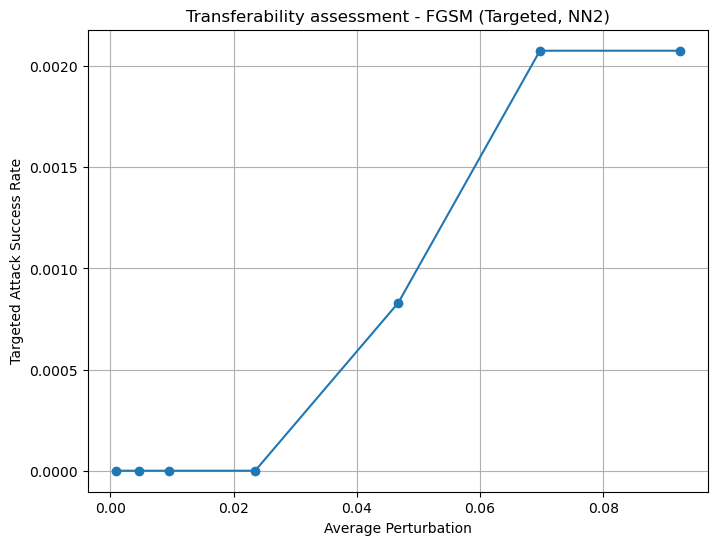

In [26]:
# Load clean test set and labels (as used for adversarial attack)
x_test, y_test = torch.load('xy_test.pt')

# Preprocessing for NN2 (ResNet50 with BGR mean subtraction)
mean_bgr = torch.tensor([91.4953, 103.8827, 131.0912]).view(1, 3, 1, 1)

def preprocess_for_nn2_batch(x):
    # x: (N, 3, 160, 160), torch or numpy, range [-1,1] or [0,1]
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    if x.min() < 0:
        x = (x + 1.0) / 2.0
    x = x * 255.0
    x = x[:, [2, 1, 0], :, :]  # RGB → BGR
    x = x - mean_bgr.to(x.device)
    return x

adv_dir = "../adv_samples/FGSM_targeted"
files = sorted([f for f in os.listdir(adv_dir) if f.endswith(".npy")])

# Compute target labels in the same way as for attack generation
num_classes = len(LABELS)
target_labels = (y_test + 1) % num_classes

epsilons, accuracies, perturbations, linf_perturbations = [], [], [], []

# Preprocess clean test images once (resize for ResNet50)
x_test_tensor = preprocess_for_nn2_batch(x_test)
x_test_tensor = F.interpolate(x_test_tensor, size=(224, 224), mode='bilinear', align_corners=False)

for file in files:
    epsilon_str = file.split("_")[-1].replace(".npy", "")
    epsilon = float(epsilon_str)
    epsilons.append(epsilon)
    print(f"\nEvaluating Targeted FGSM adversarial samples with epsilon = {epsilon}")

    x_adv = np.load(os.path.join(adv_dir, file))  # (N, 3, 160, 160)
    x_adv_tensor_raw = torch.from_numpy(x_adv).float()

    # Compute perturbation
    diff = torch.abs(x_adv_tensor_raw - x_test)
    avg_perturb = diff.mean().item()
    max_perturb = diff.max().item()

    # Preprocess adversarial images for NN2 (for prediction only)
    x_adv_tensor = preprocess_for_nn2_batch(x_adv_tensor_raw)
    x_adv_tensor = F.interpolate(x_adv_tensor, size=(224, 224), mode='bilinear', align_corners=False)

    # Batch processing for predictions (to use GPU-acceleration)
    batch_size = 64
    correct = 0
    total = 0

    for i in tqdm(range(0, x_adv_tensor.size(0), batch_size)):
        batch_adv = x_adv_tensor[i:i+batch_size].to(device)
        with torch.no_grad():
            outputs = nn2(batch_adv)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
        pred_labels = [str(LABELS[idx]).strip() for idx in preds]
        target_batch = target_labels[i:i+batch_size]
        target_label_names = [str(LABELS[idx]).strip() for idx in target_batch.numpy()]
        for p, t in zip(pred_labels, target_label_names):
            if normalize_string(p) == normalize_string(t):
                correct += 1
            total += 1

    acc = correct / total if total > 0 else 0
    accuracies.append(acc)
    perturbations.append(avg_perturb)
    linf_perturbations.append(max_perturb)

    print(
        f"Epsilon: {epsilon:.3f}, Average perturbation: {avg_perturb:.4f}, "
        f"L∞: {max_perturb:.4f}, Targeted Success Rate: {acc * 100:.4f}%"
    )

# Plot Security Evaluation Curve
plt.figure(figsize=(8, 6))
plt.plot(perturbations, accuracies, marker='o', linestyle='-')
plt.xlabel("Average Perturbation")
plt.ylabel("Targeted Attack Success Rate")
plt.title("Transferability assessment - FGSM (Targeted, NN2)")
plt.grid(True)
plt.show()

#### BIM (Targeted)


Evaluating Targeted BIM adversarial samples with epsilon = 0.001 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.80it/s]


Epsilon: 0.001, max_iter: 10, Average perturbation: 0.0009, L∞: 0.0010, Targeted Success Rate: 0.00%

Evaluating Targeted BIM adversarial samples with epsilon = 0.001 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.83it/s]


Epsilon: 0.001, max_iter: 20, Average perturbation: 0.0009, L∞: 0.0010, Targeted Success Rate: 0.00%

Evaluating Targeted BIM adversarial samples with epsilon = 0.001 and max_iter = 5


100%|██████████| 38/38 [00:03<00:00, 10.83it/s]


Epsilon: 0.001, max_iter: 5, Average perturbation: 0.0009, L∞: 0.0010, Targeted Success Rate: 0.00%

Evaluating Targeted BIM adversarial samples with epsilon = 0.005 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.83it/s]


Epsilon: 0.005, max_iter: 10, Average perturbation: 0.0043, L∞: 0.0050, Targeted Success Rate: 0.00%

Evaluating Targeted BIM adversarial samples with epsilon = 0.005 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.84it/s]


Epsilon: 0.005, max_iter: 20, Average perturbation: 0.0045, L∞: 0.0050, Targeted Success Rate: 0.00%

Evaluating Targeted BIM adversarial samples with epsilon = 0.005 and max_iter = 5


100%|██████████| 38/38 [00:03<00:00, 10.83it/s]


Epsilon: 0.005, max_iter: 5, Average perturbation: 0.0039, L∞: 0.0050, Targeted Success Rate: 0.00%

Evaluating Targeted BIM adversarial samples with epsilon = 0.01 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.83it/s]


Epsilon: 0.010, max_iter: 10, Average perturbation: 0.0080, L∞: 0.0100, Targeted Success Rate: 0.00%

Evaluating Targeted BIM adversarial samples with epsilon = 0.01 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.83it/s]


Epsilon: 0.010, max_iter: 20, Average perturbation: 0.0086, L∞: 0.0100, Targeted Success Rate: 0.00%

Evaluating Targeted BIM adversarial samples with epsilon = 0.01 and max_iter = 5


100%|██████████| 38/38 [00:03<00:00, 10.83it/s]


Epsilon: 0.010, max_iter: 5, Average perturbation: 0.0071, L∞: 0.0100, Targeted Success Rate: 0.00%

Evaluating Targeted BIM adversarial samples with epsilon = 0.025 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.82it/s]


Epsilon: 0.025, max_iter: 10, Average perturbation: 0.0172, L∞: 0.0250, Targeted Success Rate: 0.00%

Evaluating Targeted BIM adversarial samples with epsilon = 0.025 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.82it/s]


Epsilon: 0.025, max_iter: 20, Average perturbation: 0.0193, L∞: 0.0250, Targeted Success Rate: 0.00%

Evaluating Targeted BIM adversarial samples with epsilon = 0.025 and max_iter = 5


100%|██████████| 38/38 [00:03<00:00, 10.82it/s]


Epsilon: 0.025, max_iter: 5, Average perturbation: 0.0146, L∞: 0.0250, Targeted Success Rate: 0.00%

Evaluating Targeted BIM adversarial samples with epsilon = 0.05 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.82it/s]


Epsilon: 0.050, max_iter: 10, Average perturbation: 0.0283, L∞: 0.0500, Targeted Success Rate: 0.17%

Evaluating Targeted BIM adversarial samples with epsilon = 0.05 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.78it/s]


Epsilon: 0.050, max_iter: 20, Average perturbation: 0.0323, L∞: 0.0500, Targeted Success Rate: 0.21%

Evaluating Targeted BIM adversarial samples with epsilon = 0.05 and max_iter = 5


100%|██████████| 38/38 [00:03<00:00, 10.77it/s]


Epsilon: 0.050, max_iter: 5, Average perturbation: 0.0241, L∞: 0.0500, Targeted Success Rate: 0.12%

Evaluating Targeted BIM adversarial samples with epsilon = 0.075 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.76it/s]


Epsilon: 0.075, max_iter: 10, Average perturbation: 0.0375, L∞: 0.0750, Targeted Success Rate: 0.37%

Evaluating Targeted BIM adversarial samples with epsilon = 0.075 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.79it/s]


Epsilon: 0.075, max_iter: 20, Average perturbation: 0.0436, L∞: 0.0750, Targeted Success Rate: 0.29%

Evaluating Targeted BIM adversarial samples with epsilon = 0.075 and max_iter = 5


100%|██████████| 38/38 [00:03<00:00, 10.80it/s]


Epsilon: 0.075, max_iter: 5, Average perturbation: 0.0321, L∞: 0.0750, Targeted Success Rate: 0.37%

Evaluating Targeted BIM adversarial samples with epsilon = 0.1 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.76it/s]


Epsilon: 0.100, max_iter: 10, Average perturbation: 0.0466, L∞: 0.1000, Targeted Success Rate: 0.75%

Evaluating Targeted BIM adversarial samples with epsilon = 0.1 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.83it/s]


Epsilon: 0.100, max_iter: 20, Average perturbation: 0.0548, L∞: 0.1000, Targeted Success Rate: 0.50%

Evaluating Targeted BIM adversarial samples with epsilon = 0.1 and max_iter = 5


100%|██████████| 38/38 [00:03<00:00, 10.80it/s]


Epsilon: 0.100, max_iter: 5, Average perturbation: 0.0398, L∞: 0.1000, Targeted Success Rate: 0.46%


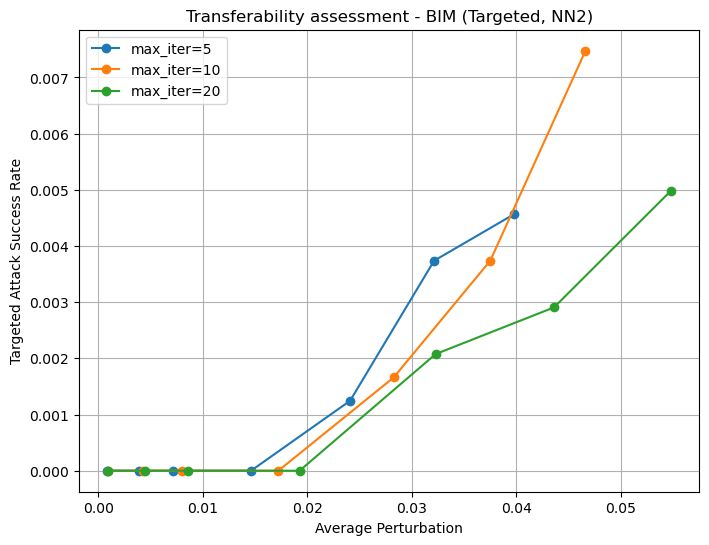

In [27]:
# Load clean test set and true labels
x_test, y_test = torch.load('xy_test.pt')  # x_test: (N, 3, 160, 160), y_test: (N,)

# Preprocessing for NN2 (ResNet50 with BGR mean subtraction)
mean_bgr = torch.tensor([91.4953, 103.8827, 131.0912]).view(1, 3, 1, 1)

def preprocess_for_nn2_batch(x):
    # x: (N, 3, 160, 160), torch or numpy, range [-1,1] or [0,1]
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    if x.min() < 0:
        x = (x + 1.0) / 2.0
    x = x * 255.0
    x = x[:, [2, 1, 0], :, :]  # RGB → BGR
    x = x - mean_bgr.to(x.device)
    return x

adv_dir = '../adv_samples/BIM_targeted'

def parse_filename(file):
    match = re.search(r'eps_([0-9.]+)_iter_([0-9]+)\.npy', file)
    if match:
        return float(match.group(1)), int(match.group(2))
    return None, None

files = sorted([f for f in os.listdir(adv_dir) if f.endswith('.npy')])

# Compute target labels as in attack generation
num_classes = len(LABELS)
target_labels = (y_test + 1) % num_classes

# Group results by max_iter
results = {}

for file in files:
    epsilon, max_iter = parse_filename(file)
    if epsilon is None or max_iter is None:
        print(f"Filename {file} does not match expected pattern.")
        continue

    print(f"\nEvaluating Targeted BIM adversarial samples with epsilon = {epsilon} and max_iter = {max_iter}")

    x_adv = np.load(os.path.join(adv_dir, file))  # (N, 3, 160, 160)
    x_adv_tensor_raw = torch.from_numpy(x_adv).float()

    # Compute perturbation
    diff = torch.abs(x_adv_tensor_raw - x_test)
    avg_perturb = diff.mean().item()
    max_perturb = diff.max().item()

    # Preprocess adversarial images for NN2 (for prediction only)
    x_adv_tensor = preprocess_for_nn2_batch(x_adv_tensor_raw)
    x_adv_tensor = F.interpolate(x_adv_tensor, size=(224, 224), mode='bilinear', align_corners=False)

    # Batch processing for predictions (to use GPU-acceleration)
    batch_size = 64
    correct = 0
    total = 0

    for i in tqdm(range(0, x_adv_tensor.size(0), batch_size)):
        batch_adv = x_adv_tensor[i:i+batch_size].to(device)
        with torch.no_grad():
            outputs = nn2(batch_adv)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
        pred_labels = [str(LABELS[idx]).strip() for idx in preds]
        target_batch = target_labels[i:i+batch_size]
        target_label_names = [str(LABELS[idx]).strip() for idx in target_batch.numpy()]
        for p, t in zip(pred_labels, target_label_names):
            if normalize_string(p) == normalize_string(t):
                correct += 1
            total += 1

    acc = correct / total if total > 0 else 0

    print(
        f"Epsilon: {epsilon:.3f}, max_iter: {max_iter}, "
        f"Average perturbation: {avg_perturb:.4f}, "
        f"L∞: {max_perturb:.4f}, "
        f"Targeted Success Rate: {acc * 100:.2f}%"
    )

    if max_iter not in results:
        results[max_iter] = {"perturbations": [], "accuracies": [], "epsilons": []}
    results[max_iter]["perturbations"].append(avg_perturb)
    results[max_iter]["accuracies"].append(acc)
    results[max_iter]["epsilons"].append(epsilon)

# Plot with different colors for each iteration
plt.figure(figsize=(8, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green']
for idx, (max_iter, vals) in enumerate(sorted(results.items())):
    plt.plot(
        vals["perturbations"], vals["accuracies"],
        marker='o', linestyle='-', color=colors[idx % len(colors)],
        label=f"max_iter={max_iter}"
    )
plt.xlabel("Average Perturbation")
plt.ylabel("Targeted Attack Success Rate")
plt.title("Transferability assessment - BIM (Targeted, NN2)")
plt.legend()
plt.grid(True)
plt.show()

#### PGD (Targeted)


Evaluating Targeted PGD adversarial samples with epsilon = 0.001 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.80it/s]


Epsilon: 0.001, max_iter: 10, Average perturbation: 0.0009, L∞: 0.0010, Targeted Success Rate: 0.00%

Evaluating Targeted PGD adversarial samples with epsilon = 0.001 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.77it/s]


Epsilon: 0.001, max_iter: 20, Average perturbation: 0.0010, L∞: 0.0010, Targeted Success Rate: 0.00%

Evaluating Targeted PGD adversarial samples with epsilon = 0.005 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.79it/s]


Epsilon: 0.005, max_iter: 10, Average perturbation: 0.0043, L∞: 0.0050, Targeted Success Rate: 0.00%

Evaluating Targeted PGD adversarial samples with epsilon = 0.005 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.81it/s]


Epsilon: 0.005, max_iter: 20, Average perturbation: 0.0046, L∞: 0.0050, Targeted Success Rate: 0.00%

Evaluating Targeted PGD adversarial samples with epsilon = 0.01 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.80it/s]


Epsilon: 0.010, max_iter: 10, Average perturbation: 0.0082, L∞: 0.0100, Targeted Success Rate: 0.00%

Evaluating Targeted PGD adversarial samples with epsilon = 0.01 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.82it/s]


Epsilon: 0.010, max_iter: 20, Average perturbation: 0.0089, L∞: 0.0100, Targeted Success Rate: 0.00%

Evaluating Targeted PGD adversarial samples with epsilon = 0.025 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.79it/s]


Epsilon: 0.025, max_iter: 10, Average perturbation: 0.0180, L∞: 0.0250, Targeted Success Rate: 0.00%

Evaluating Targeted PGD adversarial samples with epsilon = 0.025 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.80it/s]


Epsilon: 0.025, max_iter: 20, Average perturbation: 0.0199, L∞: 0.0250, Targeted Success Rate: 0.00%

Evaluating Targeted PGD adversarial samples with epsilon = 0.05 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.79it/s]


Epsilon: 0.050, max_iter: 10, Average perturbation: 0.0315, L∞: 0.0500, Targeted Success Rate: 0.12%

Evaluating Targeted PGD adversarial samples with epsilon = 0.05 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.80it/s]


Epsilon: 0.050, max_iter: 20, Average perturbation: 0.0342, L∞: 0.0500, Targeted Success Rate: 0.12%

Evaluating Targeted PGD adversarial samples with epsilon = 0.075 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.79it/s]


Epsilon: 0.075, max_iter: 10, Average perturbation: 0.0440, L∞: 0.0750, Targeted Success Rate: 0.29%

Evaluating Targeted PGD adversarial samples with epsilon = 0.075 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.81it/s]


Epsilon: 0.075, max_iter: 20, Average perturbation: 0.0470, L∞: 0.0750, Targeted Success Rate: 0.42%

Evaluating Targeted PGD adversarial samples with epsilon = 0.1 and max_iter = 10


100%|██████████| 38/38 [00:03<00:00, 10.83it/s]


Epsilon: 0.100, max_iter: 10, Average perturbation: 0.0563, L∞: 0.1000, Targeted Success Rate: 0.42%

Evaluating Targeted PGD adversarial samples with epsilon = 0.1 and max_iter = 20


100%|██████████| 38/38 [00:03<00:00, 10.79it/s]


Epsilon: 0.100, max_iter: 20, Average perturbation: 0.0596, L∞: 0.1000, Targeted Success Rate: 0.42%


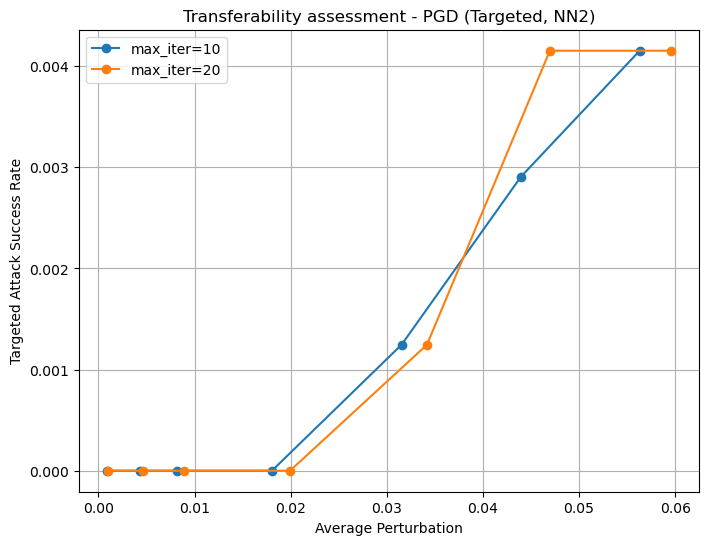

In [28]:
# Load clean test set and labels
x_test, y_test = torch.load('xy_test.pt')  # x_test: (N, 3, 160, 160), y_test: (N,)

# Preprocessing for NN2 (ResNet50 with BGR mean subtraction)
mean_bgr = torch.tensor([91.4953, 103.8827, 131.0912]).view(1, 3, 1, 1)

def preprocess_for_nn2_batch(x):
    # x: (N, 3, 160, 160), torch or numpy, range [-1,1] or [0,1]
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    if x.min() < 0:
        x = (x + 1.0) / 2.0
    x = x * 255.0
    x = x[:, [2, 1, 0], :, :]  # RGB → BGR
    x = x - mean_bgr.to(x.device)
    return x

adv_dir = '../adv_samples/PGD_targeted'

def parse_filename(file):
    match = re.search(r'eps_([0-9.]+)_iter_([0-9]+)\.npy', file)
    if match:
        return float(match.group(1)), int(match.group(2))
    return None, None

files = sorted([f for f in os.listdir(adv_dir) if f.endswith('.npy')])

# Compute target labels as in attack generation
num_classes = len(LABELS)
target_labels = (y_test + 1) % num_classes

# Group results by max_iter
results = {}

for file in files:
    epsilon, max_iter = parse_filename(file)
    if epsilon is None or max_iter is None:
        print(f"Filename {file} does not match expected pattern.")
        continue
    print(f"\nEvaluating Targeted PGD adversarial samples with epsilon = {epsilon} and max_iter = {max_iter}")

    x_adv = np.load(os.path.join(adv_dir, file))  # (N, 3, 160, 160)
    x_adv_tensor_raw = torch.from_numpy(x_adv).float()

    # Compute perturbation
    diff = torch.abs(x_adv_tensor_raw - x_test)
    avg_perturb = diff.mean().item()
    max_perturb = diff.max().item()

    # Preprocess adversarial images for NN2 (for prediction only)
    x_adv_tensor = preprocess_for_nn2_batch(x_adv_tensor_raw)
    x_adv_tensor = F.interpolate(x_adv_tensor, size=(224, 224), mode='bilinear', align_corners=False)

    # Batch processing for predictions (to use GPU-acceleration)
    batch_size = 64
    correct = 0
    total = 0

    for i in tqdm(range(0, x_adv_tensor.size(0), batch_size)):
        batch_adv = x_adv_tensor[i:i+batch_size].to(device)
        with torch.no_grad():
            outputs = nn2(batch_adv)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
        pred_labels = [str(LABELS[idx]).strip() for idx in preds]
        target_batch = target_labels[i:i+batch_size]
        target_label_names = [str(LABELS[idx]).strip() for idx in target_batch.numpy()]
        for p, t in zip(pred_labels, target_label_names):
            if normalize_string(p) == normalize_string(t):
                correct += 1
            total += 1

    acc = correct / total if total > 0 else 0

    print(
        f"Epsilon: {epsilon:.3f}, max_iter: {max_iter}, "
        f"Average perturbation: {avg_perturb:.4f}, "
        f"L∞: {max_perturb:.4f}, "
        f"Targeted Success Rate: {acc * 100:.2f}%"
    )

    if max_iter not in results:
        results[max_iter] = {"perturbations": [], "accuracies": [], "epsilons": []}
    results[max_iter]["perturbations"].append(avg_perturb)
    results[max_iter]["accuracies"].append(acc)
    results[max_iter]["epsilons"].append(epsilon)

# Plot with different colors for each iteration
plt.figure(figsize=(8, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green']
for idx, (max_iter, vals) in enumerate(sorted(results.items())):
    plt.plot(
        vals["perturbations"], vals["accuracies"],
        marker='o', linestyle='-', color=colors[idx % len(colors)],
        label=f"max_iter={max_iter}"
    )
plt.xlabel("Average Perturbation")
plt.ylabel("Targeted Attack Success Rate")
plt.title("Transferability assessment - PGD (Targeted, NN2)")
plt.legend()
plt.grid(True)
plt.show()

#### Carlini-Wagner (CW) L_Inf Method (Targeted)

Filename cw_Linf_targeted_indices.npy does not match expected pattern.

Evaluating CW-LInf targeted adversarial samples: lr=0.01, max_iter=10, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 24.34it/s]


lr: 0.01, max_iter: 10, init_const: 0.01, Average perturbation: 0.0005, L∞: 0.0156, Targeted Success Rate: 0.00%

Evaluating CW-LInf targeted adversarial samples: lr=0.01, max_iter=10, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 31.06it/s]


lr: 0.01, max_iter: 10, init_const: 0.1, Average perturbation: 0.0005, L∞: 0.0157, Targeted Success Rate: 0.00%

Evaluating CW-LInf targeted adversarial samples: lr=0.01, max_iter=1, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 31.06it/s]


lr: 0.01, max_iter: 1, init_const: 0.01, Average perturbation: 0.0066, L∞: 0.0100, Targeted Success Rate: 0.00%

Evaluating CW-LInf targeted adversarial samples: lr=0.01, max_iter=1, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 31.16it/s]


lr: 0.01, max_iter: 1, init_const: 0.1, Average perturbation: 0.0066, L∞: 0.0100, Targeted Success Rate: 0.00%

Evaluating CW-LInf targeted adversarial samples: lr=0.01, max_iter=20, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 31.42it/s]


lr: 0.01, max_iter: 20, init_const: 0.01, Average perturbation: 0.0000, L∞: 0.0000, Targeted Success Rate: 0.00%

Evaluating CW-LInf targeted adversarial samples: lr=0.01, max_iter=20, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 31.13it/s]


lr: 0.01, max_iter: 20, init_const: 0.1, Average perturbation: 0.0000, L∞: 0.0000, Targeted Success Rate: 0.00%

Evaluating CW-LInf targeted adversarial samples: lr=0.1, max_iter=10, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 30.39it/s]


lr: 0.1, max_iter: 10, init_const: 0.01, Average perturbation: 0.0000, L∞: 0.0000, Targeted Success Rate: 0.00%

Evaluating CW-LInf targeted adversarial samples: lr=0.1, max_iter=10, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 33.28it/s]


lr: 0.1, max_iter: 10, init_const: 0.1, Average perturbation: 0.0000, L∞: 0.0000, Targeted Success Rate: 0.00%

Evaluating CW-LInf targeted adversarial samples: lr=0.1, max_iter=1, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 32.68it/s]


lr: 0.1, max_iter: 1, init_const: 0.01, Average perturbation: 0.0484, L∞: 0.0999, Targeted Success Rate: 0.00%

Evaluating CW-LInf targeted adversarial samples: lr=0.1, max_iter=1, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 33.70it/s]


lr: 0.1, max_iter: 1, init_const: 0.1, Average perturbation: 0.0484, L∞: 0.0999, Targeted Success Rate: 0.00%

Evaluating CW-LInf targeted adversarial samples: lr=0.1, max_iter=20, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 33.54it/s]


lr: 0.1, max_iter: 20, init_const: 0.01, Average perturbation: 0.0000, L∞: 0.0000, Targeted Success Rate: 0.00%

Evaluating CW-LInf targeted adversarial samples: lr=0.1, max_iter=20, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 33.66it/s]


lr: 0.1, max_iter: 20, init_const: 0.1, Average perturbation: 0.0000, L∞: 0.0000, Targeted Success Rate: 0.00%


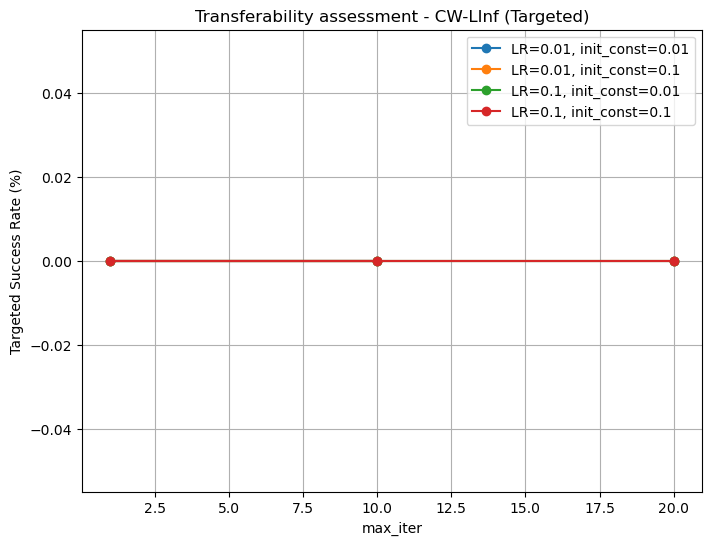

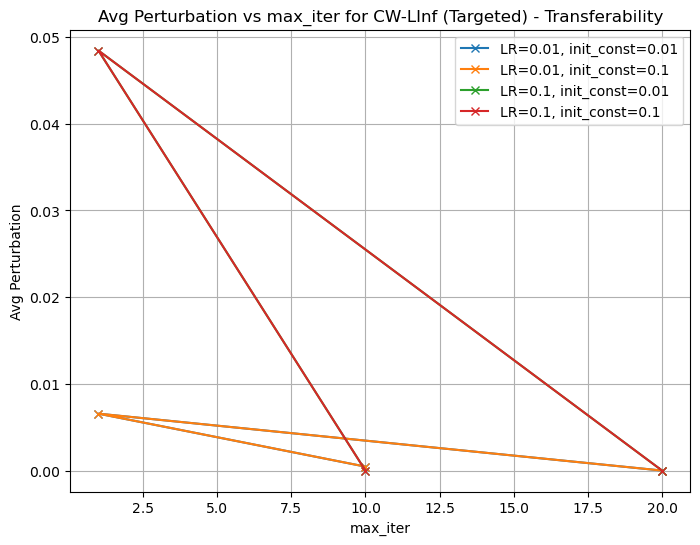

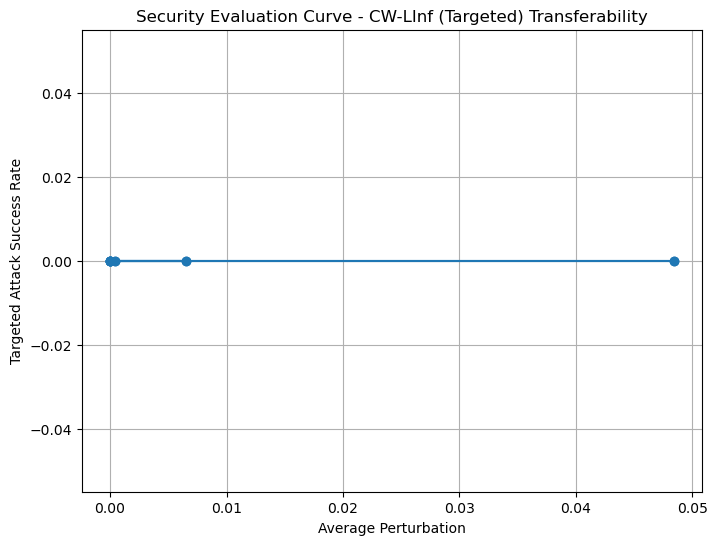

In [18]:
# Load clean test set and labels
x_test, y_test = torch.load('xy_test.pt')  # x_test: (N, 3, 160, 160), y_test: (N,)

# Load indices (must match those used for adversarial generation)
cw_Linf_targeted_indices = np.load('../adv_samples/CW_LInf_targeted/cw_Linf_targeted_indices.npy')

# Preprocessing for NN2 (ResNet50 with BGR mean subtraction)
mean_bgr = torch.tensor([91.4953, 103.8827, 131.0912]).view(1, 3, 1, 1)
def preprocess_for_nn2_batch(x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    if x.min() < 0:
        x = (x + 1.0) / 2.0
    x = x * 255.0
    x = x[:, [2, 1, 0], :, :]
    x = x - mean_bgr.to(x.device)
    return x

adv_dir = '../adv_samples/CW_LInf_targeted'
files = sorted([f for f in os.listdir(adv_dir) if f.endswith('.npy')])

num_classes = len(LABELS)
target_labels = (y_test[cw_Linf_targeted_indices] + 1) % num_classes  # Target labels for the subset

results = []

for file in files:
    match = re.search(r'lr_([0-9.]+)_maxiter_([0-9]+)_initconst_([0-9.]+)\.npy', file)
    if not match:
        print(f"Filename {file} does not match expected pattern.")
        continue
    lr = float(match.group(1))
    max_iter = int(match.group(2))
    init_const = float(match.group(3))

    print(f"\nEvaluating CW-LInf targeted adversarial samples: lr={lr}, max_iter={max_iter}, init_const={init_const}")

    # Load adversarial examples as tensor in the original domain
    x_adv = np.load(os.path.join(adv_dir, file))  # (N, 3, 160, 160)
    x_adv_tensor_raw = torch.from_numpy(x_adv).float()
    
    # Compute perturbations in the original space
    x_test_subset = x_test[cw_Linf_targeted_indices]
    diff = torch.abs(x_adv_tensor_raw - x_test_subset)
    avg_perturb = diff.mean().item()
    max_perturb = diff.max().item()

    # Preprocess adversarial images for NN2
    x_adv_tensor = preprocess_for_nn2_batch(x_adv_tensor_raw)
    x_adv_tensor = F.interpolate(x_adv_tensor, size=(224, 224), mode='bilinear', align_corners=False)

    # Batch prediction (GPU)
    batch_size = 64
    correct = 0
    total = 0

    for i in tqdm(range(0, x_adv_tensor.size(0), batch_size)):
        batch_adv = x_adv_tensor[i:i+batch_size].to(device)
        with torch.no_grad():
            outputs = nn2(batch_adv)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
        pred_labels = [str(LABELS[idx]).strip() for idx in preds]
        target_batch = target_labels[i:i+batch_size]
        target_label_names = [str(LABELS[idx]).strip() for idx in target_batch.numpy()]
        for p, t in zip(pred_labels, target_label_names):
            if normalize_string(p) == normalize_string(t):
                correct += 1
            total += 1

    acc = correct / total if total > 0 else 0

    print(
        f"lr: {lr}, max_iter: {max_iter}, init_const: {init_const}, "
        f"Average perturbation: {avg_perturb:.4f}, "
        f"L∞: {max_perturb:.4f}, "
        f"Targeted Success Rate: {acc * 100:.2f}%"
    )

    results.append({
        "learning_rate": lr,
        "max_iter": max_iter,
        "initial_const": init_const,
        "accuracy": acc,
        "average_perturbation": avg_perturb,
        "max_perturbation": max_perturb
    })

# Plot Security Evaluation Curve
df = pd.DataFrame(results)
plt.figure(figsize=(8, 6))
for (lr, init_const), group in df.groupby(['learning_rate', 'initial_const']):
    plt.plot(group["max_iter"], group["accuracy"], marker='o', label=f"LR={lr}, init_const={init_const}")
plt.xlabel("max_iter")
plt.ylabel("Targeted Success Rate (%)")
plt.title("Transferability assessment - CW-LInf (Targeted)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
for (lr, init_const), group in df.groupby(['learning_rate', 'initial_const']):
    plt.plot(group["max_iter"], group["average_perturbation"], marker='x', label=f"LR={lr}, init_const={init_const}")
plt.xlabel("max_iter")
plt.ylabel("Avg Perturbation")
plt.title("Avg Perturbation vs max_iter for CW-LInf (Targeted) - Transferability")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df["average_perturbation"], df["accuracy"], marker='o', linestyle='-')
plt.xlabel("Average Perturbation")
plt.ylabel("Targeted Attack Success Rate")
plt.title("Security Evaluation Curve - CW-LInf (Targeted) Transferability")
plt.grid(True)
plt.show()

#### Carlini-Wagner (CW) L2 Method (Targeted)

Filename cw_L2_targeted_indices.npy does not match expected pattern.

Evaluating CW-L2 targeted adversarial samples: lr=0.01, max_iter=10, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 31.24it/s]


lr: 0.01, max_iter: 10, init_const: 0.01, Average L2 perturbation: 1.1318, Max L2: 2.8010, Targeted Success Rate: 0.00%

Evaluating CW-L2 targeted adversarial samples: lr=0.01, max_iter=10, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 31.43it/s]


lr: 0.01, max_iter: 10, init_const: 0.1, Average L2 perturbation: 2.7618, Max L2: 5.2625, Targeted Success Rate: 0.00%

Evaluating CW-L2 targeted adversarial samples: lr=0.01, max_iter=1, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 30.85it/s]


lr: 0.01, max_iter: 1, init_const: 0.01, Average L2 perturbation: 0.0000, Max L2: 0.0000, Targeted Success Rate: 0.00%

Evaluating CW-L2 targeted adversarial samples: lr=0.01, max_iter=1, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 31.13it/s]


lr: 0.01, max_iter: 1, init_const: 0.1, Average L2 perturbation: 0.1922, Max L2: 2.4516, Targeted Success Rate: 0.00%

Evaluating CW-L2 targeted adversarial samples: lr=0.01, max_iter=20, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 31.25it/s]


lr: 0.01, max_iter: 20, init_const: 0.01, Average L2 perturbation: 1.2069, Max L2: 2.6901, Targeted Success Rate: 0.00%

Evaluating CW-L2 targeted adversarial samples: lr=0.01, max_iter=20, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 31.18it/s]


lr: 0.01, max_iter: 20, init_const: 0.1, Average L2 perturbation: 2.5151, Max L2: 4.4691, Targeted Success Rate: 0.00%

Evaluating CW-L2 targeted adversarial samples: lr=0.1, max_iter=10, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 32.13it/s]


lr: 0.1, max_iter: 10, init_const: 0.01, Average L2 perturbation: 1.1350, Max L2: 2.9333, Targeted Success Rate: 0.00%

Evaluating CW-L2 targeted adversarial samples: lr=0.1, max_iter=10, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 33.19it/s]


lr: 0.1, max_iter: 10, init_const: 0.1, Average L2 perturbation: 2.9536, Max L2: 5.6407, Targeted Success Rate: 0.00%

Evaluating CW-L2 targeted adversarial samples: lr=0.1, max_iter=1, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


lr: 0.1, max_iter: 1, init_const: 0.01, Average L2 perturbation: 0.1922, Max L2: 2.4516, Targeted Success Rate: 0.00%

Evaluating CW-L2 targeted adversarial samples: lr=0.1, max_iter=1, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 33.43it/s]


lr: 0.1, max_iter: 1, init_const: 0.1, Average L2 perturbation: 0.2400, Max L2: 3.0601, Targeted Success Rate: 0.00%

Evaluating CW-L2 targeted adversarial samples: lr=0.1, max_iter=20, init_const=0.01


100%|██████████| 1/1 [00:00<00:00, 33.42it/s]


lr: 0.1, max_iter: 20, init_const: 0.01, Average L2 perturbation: 1.7073, Max L2: 3.2899, Targeted Success Rate: 0.00%

Evaluating CW-L2 targeted adversarial samples: lr=0.1, max_iter=20, init_const=0.1


100%|██████████| 1/1 [00:00<00:00, 33.27it/s]


lr: 0.1, max_iter: 20, init_const: 0.1, Average L2 perturbation: 2.7747, Max L2: 5.4759, Targeted Success Rate: 0.00%


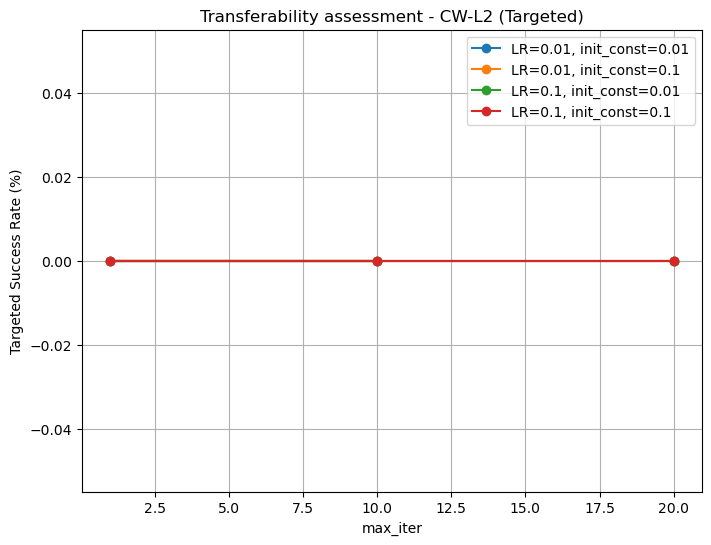

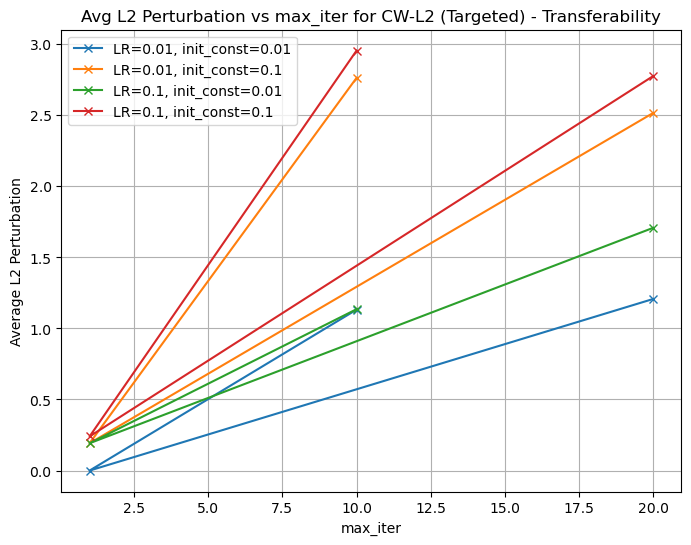

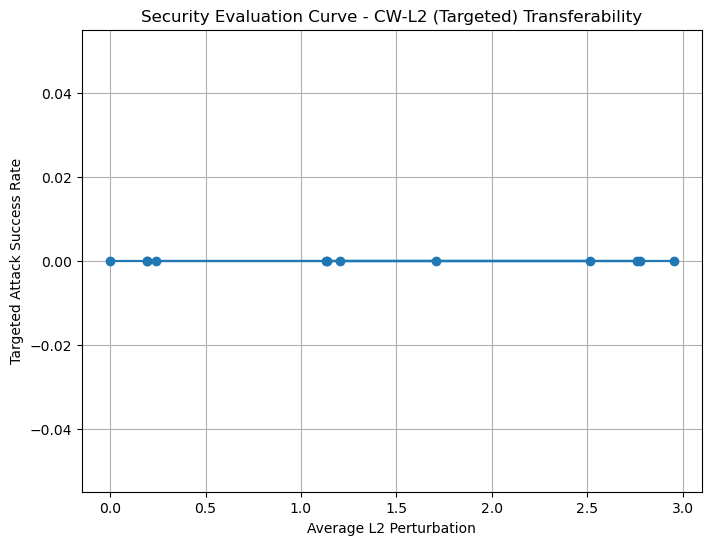

In [19]:
# Load clean test set and labels
x_test, y_test = torch.load('xy_test.pt')  # x_test: (N, 3, 160, 160), y_test: (N,)

# Load indices (must match those used for adversarial generation)
cw_L2_targeted_indices = np.load('../adv_samples/CW_L2_targeted/cw_L2_targeted_indices.npy')

# Preprocessing for NN2 (ResNet50 with BGR mean subtraction)
mean_bgr = torch.tensor([91.4953, 103.8827, 131.0912]).view(1, 3, 1, 1)
def preprocess_for_nn2_batch(x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    if x.min() < 0:
        x = (x + 1.0) / 2.0
    x = x * 255.0
    x = x[:, [2, 1, 0], :, :]
    x = x - mean_bgr.to(x.device)
    return x

adv_dir = '../adv_samples/CW_L2_targeted'
files = sorted([f for f in os.listdir(adv_dir) if f.endswith('.npy')])

num_classes = len(LABELS)
target_labels = (y_test[cw_L2_targeted_indices] + 1) % num_classes  # Target labels for the subset

results = []

for file in files:
    match = re.search(r'lr_([0-9.]+)_maxiter_([0-9]+)_initconst_([0-9.]+)\.npy', file)
    if not match:
        print(f"Filename {file} does not match expected pattern.")
        continue
    lr = float(match.group(1))
    max_iter = int(match.group(2))
    init_const = float(match.group(3))

    print(f"\nEvaluating CW-L2 targeted adversarial samples: lr={lr}, max_iter={max_iter}, init_const={init_const}")

    # Load adversarial examples as tensor in the original domain
    x_adv = np.load(os.path.join(adv_dir, file))  # (N, 3, 160, 160)
    x_adv_tensor_raw = torch.from_numpy(x_adv).float()
    
    # Compute L2 perturbations in the original space
    x_test_subset = x_test[cw_L2_targeted_indices]
    diff = x_adv_tensor_raw - x_test_subset  # (N, 3, 160, 160)
    perturbation_l2 = torch.norm(diff.view(diff.size(0), -1), p=2, dim=1)  # (N,)
    avg_l2 = perturbation_l2.mean().item()
    max_l2 = perturbation_l2.max().item()

    # Preprocess adversarial images for NN2
    x_adv_tensor = preprocess_for_nn2_batch(x_adv_tensor_raw)
    x_adv_tensor = F.interpolate(x_adv_tensor, size=(224, 224), mode='bilinear', align_corners=False)

    # Batch prediction (GPU)
    batch_size = 64
    correct = 0
    total = 0

    for i in tqdm(range(0, x_adv_tensor.size(0), batch_size)):
        batch_adv = x_adv_tensor[i:i+batch_size].to(device)
        with torch.no_grad():
            outputs = nn2(batch_adv)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
        pred_labels = [str(LABELS[idx]).strip() for idx in preds]
        target_batch = target_labels[i:i+batch_size]
        target_label_names = [str(LABELS[idx]).strip() for idx in target_batch.numpy()]
        for p, t in zip(pred_labels, target_label_names):
            if normalize_string(p) == normalize_string(t):
                correct += 1
            total += 1

    acc = correct / total if total > 0 else 0

    print(
        f"lr: {lr}, max_iter: {max_iter}, init_const: {init_const}, "
        f"Average L2 perturbation: {avg_l2:.4f}, "
        f"Max L2: {max_l2:.4f}, "
        f"Targeted Success Rate: {acc * 100:.2f}%"
    )

    results.append({
        "learning_rate": lr,
        "max_iter": max_iter,
        "initial_const": init_const,
        "accuracy": acc * 100,
        "average_l2": avg_l2,
        "max_l2": max_l2
    })

# Plot Security Evaluation Curve (transferability)
df = pd.DataFrame(results)
plt.figure(figsize=(8, 6))
for (lr, init_const), group in df.groupby(['learning_rate', 'initial_const']):
    plt.plot(group["max_iter"], group["accuracy"], marker='o', label=f"LR={lr}, init_const={init_const}")
plt.xlabel("max_iter")
plt.ylabel("Targeted Success Rate (%)")
plt.title("Transferability assessment - CW-L2 (Targeted)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
for (lr, init_const), group in df.groupby(['learning_rate', 'initial_const']):
    plt.plot(group["max_iter"], group["average_l2"], marker='x', label=f"LR={lr}, init_const={init_const}")
plt.xlabel("max_iter")
plt.ylabel("Average L2 Perturbation")
plt.title("Avg L2 Perturbation vs max_iter for CW-L2 (Targeted) - Transferability")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df["average_l2"], df["accuracy"], marker='o', linestyle='-')
plt.xlabel("Average L2 Perturbation")
plt.ylabel("Targeted Attack Success Rate")
plt.title("Security Evaluation Curve - CW-L2 (Targeted) Transferability")
plt.grid(True)
plt.show()

## Defensive Measures

### Detector of adversarial samples

In [30]:
from art.estimators.classification import TensorFlowV2Classifier
from art.defences.detector.evasion import BinaryInputDetector
from art import config
from art.utils import get_file
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

In [31]:
path = get_file('BID_eps=0.05.h5',extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/cbyfk65497wwbtn/BID_eps%3D0.05.h5?dl=1')

detector_model = tf.keras.models.load_model(path, compile=False, custom_objects={})
detector_classifier = TensorFlowV2Classifier(model=detector_model, nb_classes=2, input_shape=(32, 32, 3), clip_values=(-1,1), loss_object=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)
detector = BinaryInputDetector(detector_classifier)
# detector_model.summary() # Debug

I0000 00:00:1750864061.310605    5733 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750864061.382192    5733 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750864061.383353    5733 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750864061.388532    5733 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

To train the detector:
- we expand our training set with adversarial samples
- we label the data with 0 (original) and 1 (adversarial)

In [ ]:
# Preprocessing function for the detector (resize to 32x32x3)
def preprocess_for_detector(x):
    # x: (N, 3, 160, 160) -> (N, 160, 160, 3)
    x = np.transpose(x, (0, 2, 3, 1))
    # Resize to (N, 32, 32, 3)
    x = tf.image.resize(x, (32, 32)).numpy()
    return x

# Load full test set (benign)
x_test, y_test = torch.load('xy_test.pt')  # (N, 3, 160, 160), (N,)
x_test = x_test.numpy()
y_test = y_test.numpy()

# Train/val split
indices = np.arange(len(x_test))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=y_test)
x_train = x_test[train_idx]
x_val = x_test[val_idx]

# Load adversarial images for selected attacks
# DeepFool and Carlini-Wagner are ignored because they don't cover all the test set and can make the detector biased
adv_paths = {
    "fgsm": "../adv_samples/FGSM/fgsm_eps_0.050.npy",
    "bim": "../adv_samples/BIM/bim_eps_0.050_iter_20.npy",
    "pgd": "../adv_samples/PGD/pgd_eps_0.050_iter_20.npy",
    "fgsm_targeted": "../adv_samples/FGSM_targeted/fgsm_targeted_eps_0.100.npy",
    "bim_targeted": "../adv_samples/BIM_targeted/bim_targeted_eps_0.100_iter_20.npy",
    "pgd_targeted": "../adv_samples/PGD_targeted/pgd_targeted_eps_0.050_iter_20.npy"
}

# Preprocess benign train/val
x_train_benign = preprocess_for_detector(x_train)
x_val_benign = preprocess_for_detector(x_val)

# Preprocess adversarial train/val for each attack and concatenate
x_train_adv_all, x_val_adv_all = [], []
for name, path in adv_paths.items():
    x_adv_full = np.load(path)  # (N, 3, 160, 160)
    x_adv_train = x_adv_full[train_idx]
    x_adv_val = x_adv_full[val_idx]
    x_train_adv_all.append(preprocess_for_detector(x_adv_train))
    x_val_adv_all.append(preprocess_for_detector(x_adv_val))

x_train_adv = np.concatenate(x_train_adv_all, axis=0)
x_val_adv = np.concatenate(x_val_adv_all, axis=0)

# Dataset creation and binary labels
n_train = x_train_benign.shape[0]
n_val = x_val_benign.shape[0]

x_train_detector = np.concatenate([x_train_benign, x_train_adv], axis=0)
y_train_detector = np.concatenate([
    np.zeros((n_train,)),  # 0 = benign
    np.ones((x_train_adv.shape[0],))  # 1 = adversarial
], axis=0)

x_val_detector = np.concatenate([x_val_benign, x_val_adv], axis=0)
y_val_detector = np.concatenate([
    np.zeros((n_val,)),
    np.ones((x_val_adv.shape[0],))
], axis=0)

# Shuffle to avoid bias
x_train_detector, y_train_detector = shuffle(x_train_detector, y_train_detector, random_state=42)
x_val_detector, y_val_detector = shuffle(x_val_detector, y_val_detector, random_state=42)

# Fit the detector
detector.fit(x_train_detector, y_train_detector, nb_epochs=10, batch_size=64)

2025-06-25 17:07:43.887389: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 591667200 exceeds 10% of free system memory.
2025-06-25 17:07:48.160045: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 591667200 exceeds 10% of free system memory.
2025-06-25 17:07:50.772397: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 591667200 exceeds 10% of free system memory.
2025-06-25 17:07:53.513075: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 591667200 exceeds 10% of free system memory.
2025-06-25 17:07:56.378867: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 591667200 exceeds 10% of free system memory.
2025-06-25 17:08:15.987697: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNC

#### Evaluating the detector

W0000 00:00:1750864170.949491    5733 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750864170.950434    5733 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750864170.951134    5733 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750864170.951775    5733 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750864170.952422    5733 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750864170.953065    5733 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750864170.953704    5733 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750864170.954370    5733 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750864170.955041    5733 gp

----- Validation set -----
Flagged as adversarial: 2208
Not flagged: 1166

Ground truth: benign: 482, adversarial: 2892

Detection accuracy on validation set: 79.73%


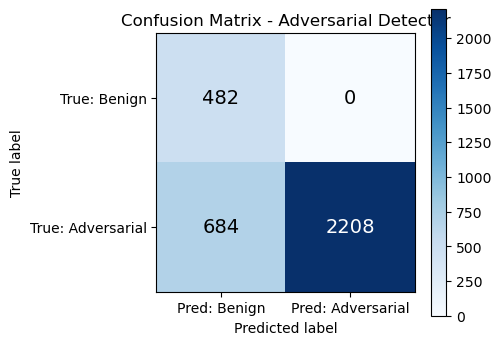


Classification report:
               precision    recall  f1-score   support

      benign       0.41      1.00      0.58       482
 adversarial       1.00      0.76      0.87      2892

    accuracy                           0.80      3374
   macro avg       0.71      0.88      0.73      3374
weighted avg       0.92      0.80      0.83      3374



In [33]:
# Evaluate the detector on the validation set
report, is_adv_pred = detector.detect(x=x_val_detector, batch_size=64)
num_adv = np.sum(is_adv_pred)
num_not_adv = len(is_adv_pred) - num_adv
print(f"----- Validation set -----\nFlagged as adversarial: {num_adv}\nNot flagged: {num_not_adv}")

# Count ground-truth benign and adversarial samples in the validation set
n_benign = np.sum(y_val_detector == 0)
n_adv_gt = np.sum(y_val_detector == 1)
print(f"\nGround truth: benign: {n_benign}, adversarial: {n_adv_gt}")

# Accuracy calculation
accuracy = np.mean(is_adv_pred == y_val_detector)
print(f"\nDetection accuracy on validation set: {accuracy*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_val_detector, is_adv_pred)
labels = ["Benign", "Adversarial"]

plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Adversarial Detector")
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, ["Pred: " + l for l in labels])
plt.yticks(tick_marks, ["True: " + l for l in labels])

# Annotate each cell with the numeric value
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Precision, Recall, F1, and accuracy
report_str = classification_report(y_val_detector, is_adv_pred, target_names=["benign", "adversarial"])
print("\nClassification report:\n", report_str)

## Authors:
- [Emanuele Relmi](github.com/Kirito-Emo)
- [Luca Concilio](github.com/Lucass282)
- [Francesco Quagliuolo](github.com/quagliofranci)
- [Giuseppe Alfonso Mangiola](github.com/PeppeMangiola)